In [1]:
import pandas as pd
import numpy as np
import re
import random
import warnings; warnings.simplefilter('ignore')
import operator
import json
from SPARQLWrapper import SPARQLWrapper, JSON
from sklearn.model_selection import train_test_split
import time

In [2]:
wikidata_endpoint = "https://query.wikidata.org/sparql"
sparql = SPARQLWrapper(wikidata_endpoint, agent='sparqlwrapper 1.8.6.dev0 (rdflib.github.io/sparqlwrapper)')

In [3]:
def update_labels(df,lst,field_name,new_field):
    cntr=0
    for item in lst:
        cntr+=1
        for idx,rows in df.iterrows():
            if rows[field_name] == item:
               df.at[idx,new_field]= cntr
    return df

In [4]:
l2_train_df = pd.read_json('../data_files/lcquad2_train_v2_23Nov.json')
l2_test_df = pd.read_json('../data_files/lcquad2_test_v2_23Nov.json')
sample_df = l2_train_df.head(0)
cntr = 0
for item in lst_l2_tmpl:
    cntr += 1
    temp_df = l2_train_df.loc[l2_train_df['template_id']==item]
    temp_df = temp_df.head(1)
    sample_df = pd.concat([sample_df,temp_df])
sample_df.to_csv('../data_files/l2_sample_tmpl.csv',index=False)

24


### 12.03.2021

In [6]:
l2_df = pd.read_json('../data_files/lcquad2_with_sparql_validity_4Nov20.json')
unq_tmpl_df = pd.read_excel('../data_files/lcquad2.1_unq_tmpl.xlsx')
l2_mentions_df = pd.read_json('../data_files/lcquad2.1_with_mentions.json')
l2_df.head(2)

,uid,NNQT_question,question,sparql_wikidata,sparql_dbpedia18,template,template_id,paraphrased_question,type,sparql_validity_wiki2020
0,19719,What is the {periodical literature} for {mouth...,What periodical literature does Delta Air Line...,select distinct ?obj where { wd:Q188920 wdt:P...,select distinct ?obj where { ?statement <http:...,<S P ?O ; ?O instanceOf Type>,5,What is Delta Air Line's periodical literature...,train,True
1,15554,What is {child of} of {husband} of {Ranavalona...,Who is the child of Ranavalona I's husband?,SELECT ?answer WHERE { wd:Q169794 wdt:P26 ?X ....,SELECT ?answer WHERE { ?statement1 <http://www...,C RCD xD . xD RDE ?E,18,What is the name of Ranavalona I's husband's c...,train,True


In [7]:
print(len(l2_df))
l2_true_df = l2_df.loc[l2_df['sparql_validity_wiki2020']==True]
print(len(l2_true_df))
print('Invalid sparql nos.: ',len(l2_df)-len(l2_true_df))
unq_tmpl_df.to_json('../data_files/lcquad2.1_unq_tmpl.json',orient='records', indent=5)

30210
25690
Invalid sparql nos.:  4520


#### list of unique templates saved in json format

In [4]:
def get_ent(qry):
    qry_arr = qry.split(' ')
    tmp_lst = list(qry_arr)
    lst_words = [x.replace('.','').replace('}','').replace('{}','') for x in tmp_lst]
    lst_ent = [x.split(':')[-1] for x in lst_words if 'wd:' in x]
    return lst_ent

In [5]:
def get_pred(qry):
    qry_arr = qry.split(' ')
    tmp_lst = list(qry_arr)
    lst_words = [x.replace('.','').replace('}','').replace('{}','') for x in tmp_lst]
    lst_pred = [x.split(':')[-1] for x in lst_words if 'wdt:' in x]
    return lst_pred

In [10]:
e,p = get_ent("SELECT DISTINCT ?sbj ?sbj_label WHERE { ?sbj wdt:P31 wd:Q1931388 . ?sbj wdt:P923 wd:Q32566 . ?sbj rdfs:label ?sbj_label . FILTER(STRSTARTS(lcase(?sbj_label), 'p')) . FILTER (lang(?sbj_label) = 'en') } LIMIT 25")
#print(e)
#print(p)
##lambda x: 1 if x==1 else 0
l2_df['ent'] = l2_df['sparql_wikidata'].apply(lambda x: get_ent(x))
l2_df['pred'] = l2_df['sparql_wikidata'].apply(lambda x: get_pred(x))
l2_df.to_json('../data_files/lcquad2.1_with_ent_pred.json',orient='records', indent=12)

#### Lcquad2.1 with entity and pred for each question saved

In [6]:
#funtion for getting list of unique entites of lcquad2.1
lst_unq_ent = []
def unq_ent_lst(ent_lst):
    global lst_unq_ent
    for item in ent_lst:
        if not item in lst_unq_ent:
           lst_unq_ent.append(item)
#l2_df['ent'].apply(lambda x:unq_ent_lst(list(x)))
#print(len(lst_unq_ent))

In [7]:
#funtion for getting list of unique relations of lcquad2.1
lst_unq_rel = []
def unq_rel_lst(rel_lst):
    global lst_unq_rel
    for item in rel_lst:
        if not item in lst_unq_rel:
           lst_unq_rel.append(item)
#l2_df['pred'].apply(lambda x:unq_rel_lst(list(x)))
#print(len(lst_unq_rel)) #3627 unique rel

In [10]:
#creating a pandas dataframe of all entites existing in lcquad2.1 and then save to csv
pdf_data_e = {'entity': lst_unq_ent}
e_df = pd.DataFrame(pdf_data_e, columns = ['entity'])
e_df.to_csv('../data_files/lcquad2.1_entities_13March21.csv', index=False)
#creating a pandas dataframe of all relations existing in lcquad2.1 and then save to csv
pdf_data_r = {'relation': lst_unq_rel}
r_df = pd.DataFrame(pdf_data_r, columns = ['relation'])
r_df.to_csv('../data_files/lcquad2.1_relations_13March21.csv', index=False)

### Counting length of the question string and finding count of bins created

In [14]:
l2_df['q_len'] = l2_df['question'].apply(lambda x: len(x))

0-25, 26-50, 50-75, .... , 276-300

In [28]:
mf = 25 #multiplying factor
lst_chr = []
lst_bin_max = []
for i in range(12):
    bin_min = i*mf
    j = i + 1
    bin_max = j*mf
    col_name = 'bin_'+str(j)
    l2_df[col_name] = l2_df['q_len'].apply(lambda x: 1 if (x>=bin_min and x<bin_max) else 0)
    print('No. of questions with question length in range {:d} to {:d} is : {:d}'.format(bin_min+1,bin_max,sum(l2_df[col_name])))
    lst_chr.append(sum(l2_df[col_name]))
    lst_bin_max.append(bin_max)

No. of questions with question length in range 1 to 25 is : 393
No. of questions with question length in range 26 to 50 is : 9354
No. of questions with question length in range 51 to 75 is : 14149
No. of questions with question length in range 76 to 100 is : 4827
No. of questions with question length in range 101 to 125 is : 1155
No. of questions with question length in range 126 to 150 is : 238
No. of questions with question length in range 151 to 175 is : 60
No. of questions with question length in range 176 to 200 is : 19
No. of questions with question length in range 201 to 225 is : 7
No. of questions with question length in range 226 to 250 is : 2
No. of questions with question length in range 251 to 275 is : 1
No. of questions with question length in range 276 to 300 is : 5


In [57]:
#Storing this in a dataframe
pdf_data_v = {'num_of_questions': lst_chr, 'characters_max': lst_bin_max}
new_df = pd.DataFrame(pdf_data_v, columns = ['num_of_questions','characters_max'])
new_df.head(2)

,num_of_questions,characters_max
0,393,25
1,9354,50


In [62]:
#average size of a question
avg = 0
sm = 0
for idx,row in new_df.iterrows():
    sm += row['num_of_questions'] * row['characters_max'] 
avg = sm/sum(new_df['num_of_questions'])
print(avg)

73.47318768619662


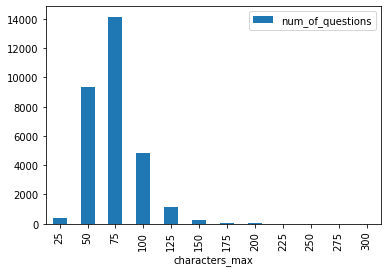

In [58]:
new_df.plot(kind ='bar',x='characters_max', y='num_of_questions')

### Conclusion: 15 questions have length > 200

In [8]:
#funtion for getting list of unique relations of lcquad2.1
lst_rel = []
def unq_rel(rel_lst):
    global lst_rel
    for item in rel_lst:
        lst_rel.append(item)

In [16]:
l2_df['pred'].apply(lambda x:unq_rel(list(x)))
bb=dict(zip(lst_rel,[lst_rel.count(i) for i in lst_rel]))
cd = sorted(bb.items(),key=operator.itemgetter(1),reverse=True)
with open('../data_files/lcquad2.1_rel_freq_14March21.json', 'w') as fp:
     json.dump(cd, fp, indent=1)
#later replace square brackets by curly bracktes and use : to make a dict on the downoaded file

### 18 March 2021:  Correcting questions with .0 as value in sparql

In [17]:
#unans_df = pd.read_json('../data_files/unans_intm/unans_class_6.json')
unans_df = pd.read_json('../data_files/lcquad2_unans_ques_v3.json')
print(len(unans_df))

In [9]:
ctr = 0
def check_zero(sw):
    global ctr
    val = False
    words_arr = sw.split(' ')
    for item in words_arr:
        if 'filter(contains(' in item:
            
            if ".0'" in item:
               val_after_decimal =item.split('.')[-1]
               if val_after_decimal[:2] == "0'":
                  val = True
                  print(item)
                  ctr += 1
                  break
            else:
               val = False
    return val

In [10]:
ctr_replaces = 0
def replace_qry(sw):
    global ctr_replaces
    effective_qry = ''
    words_arr = sw.split(' ')
    for item in words_arr:
        if 'filter(contains(' in item:
            if ".0'" in item:
               val_after_decimal =item.split('.')[-1]
               if val_after_decimal[:2] == "0'":
                  effective_qry += re.sub("[\.].*?[\']", "'", item) + ' ' 
                  ctr_replaces += 1
               else:
                 effective_qry += item + ' '   
            else:
               effective_qry += item + ' '
        else:
          effective_qry += item + ' '
    return effective_qry

In [82]:
sel_unans_df['zero_present'] = sel_unans_df['sparql_wikidata'].apply(lambda x: check_zero(x))
sel_unans_df['effective_qry'] = sel_unans_df['sparql_wikidata'].apply(lambda x: replace_qry(x))
zero_df = sel_unans_df.loc[sel_unans_df['zero_present']==True]
print(len(zero_df))
print(ctr) #222
zero_df.to_csv('../data_files/unans_intm/unans_without_point0.csv',index=False)

filter(contains(?x,'4703.0'))
filter(contains(?x,'20.0'))
filter(contains(?x,'20.0'))
filter(contains(?x,'300.0'))
filter(contains(?x,'26.0'))
filter(contains(?x,'36.0'))
filter(contains(?x,'108150.0'))
filter(contains(?x,'491524.0'))
filter(contains(?x,'836141.0'))
filter(contains(?x,'94.0'))
filter(contains(?x,'230873.0'))
filter(contains(?x,'209292.0'))
filter(contains(?x,'1.0'))
filter(contains(?x,'60.0'))
filter(contains(?x,'4.0'))
filter(contains(?x,'345425.0'))
filter(contains(?x,'146115.0'))
filter(contains(?x,'433.0'))
filter(contains(?x,'150262.0'))
filter(contains(?x,'19233.0'))
filter(contains(?x,'10.0'))
filter(contains(?x,'6381.0'))
filter(contains(?x,'36388.0'))
filter(contains(?x,'452000.0'))
filter(contains(?x,'842454.0'))
filter(contains(?x,'140703.0'))
filter(contains(?x,'324198.0'))
filter(contains(?x,'385433.0'))
filter(contains(?x,'850000.0'))
filter(contains(?x,'75391.0'))
filter(contains(?x,'157.0'))
filter(contains(?x,'4.0'))
filter(contains(?x,'531.0'))
filter

### Revising the unanswered json file after successful replacement of .0 in sparql_wikidata

In [87]:
lst_unanswered_uid = list(unans_df['uid'])
print(len(lst_unanswered_uid))
lst_answered_uid = list(zero_df['uid'])
print(len(lst_answered_uid))
lst_rev_unanswered_uid = [x for x in lst_unanswered_uid if x not in lst_answered_uid]
print(len(lst_rev_unanswered_uid))
unans_df = unans_df.loc[unans_df.uid.isin(lst_rev_unanswered_uid)]
print(len(unans_df)) #3567
unans_df = unans_df.drop(columns=['template_id'])
print(len(unans_df.columns))  #12

3789
222
3567


In [11]:
#function to map class id to template id, 25,26 to 8,9
def ren(x):
    if x == 25:
       return 8
    elif x == 26:
       return 9
    else:
       return x

In [95]:
unans_df['template_id'] = unans_df['class_id'].apply(lambda x: ren(x))
unans_df = unans_df.drop(columns=['class_id'])
unans_df.to_json('../data_files/lcquad2_unans_ques_v4_18March21.json',orient='records', indent=12)

### 21 March 2021: Separate all unswered questions template wise and save all files

In [12]:
for i in range(24):
    j = i + 1
    sel_df = unans_df.loc[unans_df['template_id'] == j]
    file_name = '../data_files/unans_ques_18March21/lcquad2.1_unans_ques_T'+str(j)+'_18March21.json'
    sel_df.to_json(file_name,orient='records', indent=12)
    print(len(sel_df))

NameError: name 'unans_df' is not defined

Revising Latest version of LCQuAD2.1 file with revised sparql queries wherever possible

In [25]:
new_qry_df = pd.read_csv('../data_files/lcq2_sparqls_without_point0_18March.csv')
print(len(new_qry_df)) # uid, effective_qry are the required usable fields
lcq2_with_mentions_df = pd.read_json('../data_files/lcquad2.1_with_mentions.json')
print(len(lcq2_with_mentions_df))

222
29855


In [11]:
def func_rep_qry(curr_uid,curr_qry):
    eff_qry_df = new_qry_df.loc[new_qry_df['uid']==curr_uid]
    if eff_qry_df.empty:
       return curr_qry
    else:
       return eff_qry_df['effective_qry'].values[0]

In [26]:
lcq2_with_mentions_df['new_sparql_wikidata'] = lcq2_with_mentions_df.apply(lambda row: func_rep_qry(row['uid'], row['sparql_wikidata']), axis=1)
print(len(lcq2_with_mentions_df))

29855


In [39]:
lcq2_with_mentions_df = lcq2_with_mentions_df.drop(columns=['sparql_wikidata'])
lcq2_with_mentions_df = lcq2_with_mentions_df.rename(columns={'new_sparql_wikidata':'sparql_wikidata'})
#checking if the effective qry has now taken place of old sparql_wikidata qry
print(lcq2_with_mentions_df.loc[lcq2_with_mentions_df['uid']==6826]['sparql_wikidata'].values[0])

SELECT ?value WHERE { wd:Q753 p:P2102 ?s . ?s ps:P2102 ?x filter(contains(?x,'4703')) . ?s pq:P2077 ?value} 


In [47]:
l2_wm_df = lcq2_with_mentions_df[['uid', 'NNQT_question', 'question', 'sparql_wikidata', 'sparql_dbpedia18', 'template',
       'template_id', 'paraphrased_question', 'type', 'answer',
       'entity_mentions_question', 'entity_mentions_question_paraphrased']]

In [48]:
#splitting the main dataset in train and test
lcq2_with_mentions_train_df = l2_wm_df.loc[lcq2_with_mentions_df['type']=='train']
print(len(lcq2_with_mentions_train_df))
lcq2_with_mentions_test_df = l2_wm_df.loc[lcq2_with_mentions_df['type']=='test']
print(len(lcq2_with_mentions_test_df))

23886
5969


#### So, our cleaned LCQuAD2.0.1 dataset will have 23886 training qiestions and 5969 test questions

In [49]:
#writing train test merged file
l2_wm_df.to_json('../data_files/lcquad2.1_with_mentions_21March.json',orient='records', indent=len(l2_wm_df.columns))
#writing train file
lcq2_with_mentions_train_df.to_json('../data_files/lcquad2.1_with_mentions_train_21March.json',orient='records', indent=len(lcq2_with_mentions_train_df.columns))
#writing test file
lcq2_with_mentions_test_df.to_json('../data_files/lcquad2.1_with_mentions_test_21March.json',orient='records', indent=len(lcq2_with_mentions_test_df.columns))

### 25.03.2021 Files without mention

In [52]:
l2_merged_wo_mention_df = l2_wm_df[['uid', 'NNQT_question', 'question', 'sparql_wikidata',
       'sparql_dbpedia18', 'template', 'template_id', 'paraphrased_question',
       'type']]
#splitting the main dataset in train and test
lcq2_wo_mentions_train_df = l2_merged_wo_mention_df.loc[lcq2_with_mentions_df['type']=='train']
print(len(lcq2_wo_mentions_train_df))
lcq2_wo_mentions_test_df = l2_merged_wo_mention_df.loc[lcq2_with_mentions_df['type']=='test']
print(len(lcq2_wo_mentions_test_df))
#writing train test merged file
l2_merged_wo_mention_df.to_json('../data_files/lcquad2.0.1.json',orient='records', indent=len(l2_merged_wo_mention_df.columns))
#writing train file
lcq2_wo_mentions_train_df.to_json('../data_files/lcquad2.0.1_train.json',orient='records', indent=len(lcq2_wo_mentions_train_df.columns))
#writing test file
lcq2_wo_mentions_test_df.to_json('../data_files/lcquad2.0.1_test.json',orient='records', indent=len(lcq2_wo_mentions_test_df.columns))

23886
5969


### 30.03.2021 PoS tagging for LCQuAD2 questions

In [13]:
import nltk
from nltk.corpus import state_union
from nltk.tokenize import PunktSentenceTokenizer

In [15]:
#lcq2_train_df = pd.read_json('../data_files/lcquad2.0.1_train.json') 
#lcq2_test_df = pd.read_json('../data_files/lcquad2.0.1_test.json') 

In [16]:
def process_content(lst):
    lst_all = []
    try:
       for i in lst:
           words = nltk.word_tokenize(i)
           tagged = nltk.pos_tag(words)
           lst_all.append(tagged)
           #print(tagged)
    except Exception as e:
       print(str(e))
    return lst_all

In [17]:
lst_gold_pos = ['CC','CD','DT','EX','FW','IN','JJ','JJR','JJS','LS','MD','NN','NNS','NNP','NNPS','PDT',
'POS','PRP','PRP$','RB','RBR','RBS','RP','TO','UH','VB','VBG','VBD','VBN','VBP','VBZ','WDT','WP','WRB']

In [18]:
#function to add question_with_pos and pos for each question block of the dataframe
def format_tags(lst_tagged_ques,df):
    lst_formatted_ques = []
    lst_PoS = []
    for item in lst_tagged_ques:
        st_item = str(item)
        st_item = st_item.replace('"\'s"', "'s'").replace("''","").replace("``","")
        temp = st_item.replace("', '","/").replace("'), ('"," ").replace("[('","").replace("')]","")
        #now collecting only the PoS for each ques
        sent_arr = temp.split(' ')
        pos_st = ''
        for j in range(len(sent_arr)):
            s = (sent_arr[j].split('/')[-1])
            result = re.sub(r'[^A-Z]', '', s)
            if result in lst_gold_pos:
               #result = result.replace('(','').replace(')','').replace('[','').replace(']','').replace("'",'').replace('"','').replace(',','')
               pos_st += result + ' ' 
        pos_st = pos_st.strip()
        lst_PoS.append(pos_st)
        lst_formatted_ques.append(temp)
    df['question_pos'] = lst_PoS
    df['question_with_pos'] = lst_formatted_ques
    return df

In [72]:
lcq2_train_df = format_tags(process_content(lcq2_train_df.question),lcq2_train_df)
lcq2_test_df = format_tags(process_content(lcq2_test_df.question),lcq2_test_df)

### Forming 1 Hot Vector from the POS

In [19]:
def get_1HV(st):
    one_hot_vec = np.zeros(len(lst_gold_pos))
    arr_pos = st.split(' ')
    for i in range(len(arr_pos)):
        if arr_pos[i] in lst_gold_pos:
           one_hot_vec[lst_gold_pos.index(arr_pos[i])] += 1
    return one_hot_vec

In [87]:
#creating new column for PoS vector in train and test sets
lcq2_train_df['ques_pos_vec'] = lcq2_train_df.question_pos.apply(lambda x: get_1HV(x))
lcq2_test_df['ques_pos_vec'] = lcq2_test_df.question_pos.apply(lambda x: get_1HV(x))
#writing train file
lcq2_train_df.to_json('../data_files/lcquad2.0.1_train_pos_3April.json', orient='records', indent=len(lcq2_train_df.columns))
#writing test file
lcq2_test_df.to_json('../data_files/lcquad2.0.1_test_pos_3April.json', orient='records', indent=len(lcq2_test_df.columns))

### forming BERT embeddings of questions

In [20]:
import mxnet as mx
from bert_embedding import BertEmbedding

In [21]:
#when doing on cpu
#ctx = mx.cpu()
#when doing on gpu
#import torch
#torch.cuda.is_available()
ctx = mx.gpu(2)  #2 is the GPU device on which the bert embeddings should be created
bert = BertEmbedding(ctx=ctx)

In [22]:
def ConvertVectorSetToVecAverageBased(vectorSet, ignore = []):
    if len(ignore) == 0:        
        return np.mean(vectorSet, axis = 0)
    else:
        return np.dot(np.transpose(vectorSet),ignore)/sum(ignore)

In [23]:
#function to convert sentences to BERT Embeddings
def phrase_vectors(sentences):
    embeddings = bert(sentences)
    avgembs = [ConvertVectorSetToVecAverageBased(x[1]) for x in embeddings]
    return avgembs

In [105]:
#creating test and train embeddings
train_emb = phrase_vectors(list(lcq2_train_df.question))
test_emb = phrase_vectors(list(lcq2_test_df.question))

In [106]:
#creating a separate df as exisitng will become too heavy
pdf_data_train = {'uid': list(lcq2_train_df.uid), 'ques_emb': train_emb}
train_emb_df = pd.DataFrame(pdf_data_train, columns = ['uid','ques_emb'])
pdf_data_test = {'uid': list(lcq2_test_df.uid), 'ques_emb': test_emb}
test_emb_df = pd.DataFrame(pdf_data_test, columns = ['uid','ques_emb'])

In [107]:
#write the embeddings to train and test files respectively
#writing train file
train_emb_df.to_json('../data_files/lcquad2.0.1_train_ques_emb_5April.json', orient='records', indent=len(train_emb_df.columns))
#writing test file
test_emb_df.to_json('../data_files/lcquad2.0.1_test_ques_emb_5April.json', orient='records', indent=len(test_emb_df.columns))

### Processing CFQ Dataset

In [2]:
cfq_countG_200_train_df = pd.read_csv('../data_files/cfq_train_countG_200.csv')
cfq_countG_200_test_df = pd.read_csv('../data_files/cfq_test_countG_200.csv')

FileNotFoundError: [Errno 2] File ../data_files/cfq_train_countG_200.csv does not exist: '../data_files/cfq_train_countG_200.csv'

In [19]:
#adding PoS tags
cfq_countG_200_train_df = format_tags(process_content(cfq_countG_200_train_df.question),cfq_countG_200_train_df)
cfq_countG_200_test_df = format_tags(process_content(cfq_countG_200_test_df.question),cfq_countG_200_test_df)
cfq_countG_200_test_df.head(2)

,cid,quesTemplate,question,template,label,question_pos,question_with_pos
0,21025,[entity] [ROLE_SIMPLE]* [VP_SIMPLE]* [entity],"Did Tetsuo: The Iron Man's writer, editor, cin...",2,1,NNP NNP DT NNP NNP POS NN NN NN CC NN JJ JJ NN...,Did/NNP Tetsuo/NNP :/: The/DT Iron/NNP Man/NNP...
1,21245,[entity] [ROLE_SIMPLE]* [VP_SIMPLE]* [entity],"Did The Brown Bunny's art director, costume de...",2,1,NNP DT NNP NNP POS NN NN JJ NN NN CC NN NN NN ...,Did/NNP The/DT Brown/NNP Bunny/NNP s/POS art/N...


In [24]:
#adding one hot vector
cfq_countG_200_train_df['ques_pos_vec'] = cfq_countG_200_train_df.question_pos.apply(lambda x: get_1HV(x))
cfq_countG_200_test_df['ques_pos_vec'] = cfq_countG_200_test_df.question_pos.apply(lambda x: get_1HV(x))
print(phrase_vectors(list(cfq_countG_200_train_df.question)[0]))

[array([-3.34343910e-01, -1.69111043e-01,  5.41629910e-01, -3.41447085e-01,
        1.07726894e-01, -1.34483248e-01,  3.07863533e-01, -4.95592415e-01,
        7.37014338e-02, -1.01172817e+00, -6.82764769e-01, -1.54492393e-01,
        2.24471167e-01,  2.92491019e-01,  3.46217781e-01,  1.16154023e-01,
        5.61201096e-01,  1.68689191e-01,  5.94405651e-01,  8.96436572e-01,
       -1.91383958e-01,  2.17015460e-01,  1.04864545e-01,  2.03479081e-01,
        3.59113604e-01,  8.28459322e-01, -4.16150361e-01,  2.94580132e-01,
       -1.87106282e-01,  9.22950983e-01,  3.39216620e-01, -6.80169761e-01,
       -4.65891391e-01,  3.21101427e-01, -1.29132807e-01, -7.44363904e-01,
        1.87434629e-03, -1.46399796e-01, -1.18259859e+00, -8.86678249e-02,
       -1.47896893e-02, -3.38760078e-01,  1.77393317e-01, -5.98193467e-01,
       -9.75571573e-04,  8.10002685e-01,  7.23646402e-01,  1.54991180e-01,
       -1.79131478e-01, -5.71744859e-01, -6.78837299e-01, -2.81350851e-01,
       -3.95000398e-01, 

In [29]:
cfq_countG_200_train_df['ques_emb'] = phrase_vectors(list(cfq_countG_200_train_df.question))
cfq_countG_200_test_df['ques_emb'] = phrase_vectors(list(cfq_countG_200_test_df.question))
#write the embeddings to train and test files respectively
#writing train file
cfq_countG_200_train_df.to_json('../data_files/cfq_countG_200_train_emb_5April.json', orient='records', indent=len(cfq_countG_200_train_df.columns))
#writing test file
cfq_countG_200_test_df.to_json('../data_files/cfq_countG_200_test_emb_5April.json', orient='records', indent=len(cfq_countG_200_test_df.columns))

### Updating LCQuAD2.0 mentions file with Class to filter out Entities

In [39]:
#loading train and test earlier version of files
l2_train_with_emb_df = pd.read_json('../data_files/lcquad2.0.1_train_ques_emb_5April.json')
l2_test_with_emb_df = pd.read_json('../data_files/lcquad2.0.1_test_ques_emb_5April.json') 

In [22]:
qry_pt1 = 'select distinct ?label where { wd:'
qry_pt2 = ' rdfs:label ?label . FILTER (langMatches( lang(?label), "EN" ) ) } LIMIT 1'

In [21]:
#function to fetch answer from wikidata endpoint
def fetch_label(qry):
    res = ''
    sparql.setQuery(qry)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert() 
    for item in results['results']['bindings']: 
        res = item['label']['value'].lower().strip()
    return res

In [2]:
#loading file with mentions
l2_train_with_mentions_df = pd.read_json('../data_files/lcquad2.1_with_mentions_train_21March.json')
l2_test_with_mentions_df = pd.read_json('../data_files/lcquad2.1_with_mentions_test_21March.json') 

In [39]:
#check if P31 occurs more than once in entire lcquad sparql
print(len(l2_test_with_mentions_df.sparql_wikidata))
lst_p31_occurrence = []
for i in range(len(l2_test_with_mentions_df.sparql_wikidata)):
    lst_p31_occurrence.append(len(re.findall('wdt:P31', l2_test_with_mentions_df.sparql_wikidata[i])))
print(sum(lst_p31_occurrence))
print(lst_p31_occurrence.count(2))
print(lst_p31_occurrence.index(2))

5969
1524


In [24]:
def fetch_lst_entites_for_df(df):
    excp_ctr = 0
    try:
       global_ent_list_for_df = []
       for j in range(len(df)):
           #list of answer labels for this particular question block
           temp_lst_ans_labels = []
           #list of entites for this particular question block
           temp_lst_entities = []
           if 'wdt:P31' in df.sparql_wikidata[j]:
               temp_sparql = df.sparql_wikidata[j]
               temp_lst_qid = []
               #find triples enclosed between the curly braces
               temp_triples = temp_sparql[temp_sparql.find("{")+1:temp_sparql.find("}")]
               #split the triples on . and then check for presence of P31 in each triple to extract respective QIDs
               temp_tpl_arr = temp_triples.split('.')
               for item in temp_tpl_arr:
                   if 'wdt:P31' in item:
                       arr = item.split(' ')
                       for i in arr:
                           if 'wd:' in i:
                               qid = i.split(':')[-1].replace(' ','').replace('}','')
                               if not qid in temp_lst_qid:
                                  temp_lst_qid.append(qid)
               #temp_lst_qid contains list of all wd wiki qids of P31 relation for this particular question               
               for item in temp_lst_qid:
                   qry = qry_pt1 + item + qry_pt2
                   curr_label = fetch_label(qry)    
                   if not curr_label in temp_lst_ans_labels:
                      temp_lst_ans_labels.append(curr_label)
           #forming the list of entites for this particular question
           for i in range(len(df.entity_mentions_question[j])):
               temp_dct = df.entity_mentions_question[j][i]
               if len(temp_dct)>0:
                  try:
                     if temp_dct['type'] == 'E':
                        current_lbl = str(temp_dct['label']).lower().strip()
                        if not current_lbl in temp_lst_ans_labels:
                           if not current_lbl in temp_lst_entities:
                              temp_lst_entities.append(current_lbl)
                  except:
                     excp_ctr+=1
                     pass
           global_ent_list_for_df.append(temp_lst_entities)
    except:
       print('exception in iteration ',j) 
    print(excp_ctr)
    return global_ent_list_for_df

In [104]:
l2_test_with_mentions_df['entites'] = fetch_lst_entites_for_df(l2_test_with_mentions_df)
l2_train_with_mentions_df['entites'] = fetch_lst_entites_for_df(l2_train_with_mentions_df)

296


In [107]:
#writing train file
l2_train_with_mentions_df.to_json('../data_files/lcquad2.1_with_mentions_train_18April.json',orient='records', indent=len(l2_train_with_mentions_df.columns))
#writing test file
l2_test_with_mentions_df.to_json('../data_files/lcquad2.1_with_mentions_test_18April.json',orient='records', indent=len(l2_test_with_mentions_df.columns))

In [25]:
def fetch_nulls_in_ent(df):
    ctr_null_lists = 0
    for i in range(len(df.entites)):
        if len(df.entites[i]) == 0:
           ctr_null_lists+=1
    print('No of null lists in entities is ',ctr_null_lists)

In [108]:
fetch_nulls_in_ent(l2_test_with_mentions_df)
fetch_nulls_in_ent(l2_train_with_mentions_df)

No of null lists in entities in test file is  1351
No of null lists in entities in train file is  5592


In [26]:
def fetch_masked_ques(dfq,dfe,ide,ent):
    lst_mq = []
    for idx,row in dfq.iterrows():
        #extracting question from 1st df
        temp_ques = str(row['question']).lower()
        #extracting entity list for each question from another df
        try:
            temp_ent_lst = dfe[dfe[ide]==row[ide]][ent].values[0]
        except:
            temp_ent_lst = []
        #counter to keep track of no of entites in the entity list which needs to be masked
        ctr_ent = 0
        for i in range(len(temp_ent_lst)):
            ctr_ent += 1
            if str(temp_ent_lst[i]).lower() in temp_ques:
               temp_ques = temp_ques.replace(str(temp_ent_lst[i]).lower(),'[Entity'+str(ctr_ent)+']')
        lst_mq.append(temp_ques)
    dfq['ent_masked_ques'] = lst_mq
    return dfq

In [79]:
#function to add masked questions to existig train and test dataframes
lcq2_test_df = fetch_masked_ques(lcq2_test_df,l2_test_with_mentions_df,'uid','entites')
lcq2_train_df = fetch_masked_ques(lcq2_train_df,l2_train_with_mentions_df,'uid','entites')

In [140]:
print(lcq2_test_df['ent_masked_ques'].head(1))

0    who is the  country for head of state of [Enti...
Name: ent_masked_ques, dtype: object


In [155]:
#PoS tagging of these ent masked questions and getting 1 hot vector of same
lcq2_train_df = format_tags(process_content(lcq2_train_df.question),lcq2_train_df)
lcq2_test_df = format_tags(process_content(lcq2_test_df.question),lcq2_test_df)

In [149]:
#forming 1 hot vector of PoS Tags
lcq2_train_df['ques_pos_vec'] = lcq2_train_df.question_pos.apply(lambda x: get_1HV(x))
lcq2_test_df['ques_pos_vec'] = lcq2_test_df.question_pos.apply(lambda x: get_1HV(x))
#Now, find embeddings of questions after masking the entities as obtained here utilizing in 
#l2_train_with_emb_df & l2_test_with_emb_df based on uid mapping
lcq2_train_df['ques_emb'] = phrase_vectors(list(lcq2_train_df.ent_masked_ques))
lcq2_test_df['ques_emb'] = phrase_vectors(list(lcq2_test_df.ent_masked_ques))

In [157]:
lcq2_train_df.to_json('../data_files/lcquad2.0.1_train_ent_mask_ques_emb_18April.json',orient='records', indent=len(lcq2_train_df.columns))
#writing test file
lcq2_test_df.to_json('../data_files/lcquad2.0.1_test_ent_mask_ques_emb_18April.json',orient='records', indent=len(lcq2_test_df.columns))

In [35]:
lcq2_train_df = pd.read_json('../data_files/lcquad2.0.1_train_ent_mask_ques_emb_18April.json')
lcq2_test_df = pd.read_json('../data_files/lcquad2.0.1_test_ent_mask_ques_emb_18April.json')
lcq2_test_df.ent_masked_ques.head(5)

0    who is the  country for head of state of [Enti...
1    what was the population of [Entity1] in 2009-0-0?
2    which female actress is the voice over on [Ent...
3    what is nominated for of [Entity1] that is for...
4    what was the population of [Entity1] on 1-1-2013?
Name: ent_masked_ques, dtype: object

In [27]:
#function to return list of those uids which have no entities asfter processing mentions file
def fetch_uid_no_ent(df):
    lst_uids = []
    for idx,row in df.iterrows():
        if not '[Entity' in row['ent_masked_ques']:
            lst_uids.append(row['uid'])
    return lst_uids

In [37]:
lst_train_uids_without_ent = fetch_uid_no_ent(lcq2_train_df)
lst_test_uids_without_ent = fetch_uid_no_ent(lcq2_test_df)
print('No. of train blocks without entity: ',len(lst_train_uids_without_ent))
print('No. of test blocks without entity: ',len(lst_test_uids_without_ent))
lcq2_train_with_wop31_ent_df = lcq2_train_df.loc[lcq2_train_df.uid.isin(lst_train_uids_without_ent)]
lcq2_test_with_wop31_ent_df = lcq2_test_df.loc[lcq2_test_df.uid.isin(lst_test_uids_without_ent)]

No. of train blocks without entity:  7178
No. of test blocks without entity:  1763


#### Fetching entity labels for entities whose labels could not be fetched using mentions file

In [28]:
def fetch_ent_with_labels_df(df):
    excp_ctr = 0
    try:
       global_ent_list = []
       for j in range(len(df)):
           #list of answer labels for this particular question block
           temp_lst_ans_labels = []
           #list of entites for this particular question block
           temp_lst_entities = []
           temp_sparql = df.sparql_wikidata.values[j]
           temp_lst_qid = []
           #find triples enclosed between the curly braces
           temp_triples = temp_sparql[temp_sparql.find("{")+1:temp_sparql.find("}")]
           #split the triples on . and then check for presence of P31 in each triple to extract respective QIDs
           temp_tpl_arr = temp_triples.split('.')
           for item in temp_tpl_arr:
               #now, if P31 is not present, then that is the entity we need to fetch the label for
               if not 'wdt:P31' in item:
                  arr = item.split(' ')
                  for i in arr:
                      if 'wd:' in i:
                          qid = i.split(':')[-1].replace(' ','').replace('}','')
                          if not qid in temp_lst_qid:
                             temp_lst_qid.append(qid)
           #temp_lst_qid contains list of all wd wiki qids of P31 relation for this particular question   
           for item in temp_lst_qid:
               qry = qry_pt1 + item + qry_pt2
               curr_label = fetch_label(qry)    
               if not curr_label in temp_lst_ans_labels:
                  temp_lst_ans_labels.append(curr_label)
           global_ent_list.append(temp_lst_ans_labels)
    except Exception as ex:
       print('exception in iteration ',j)
       print(ex)
    df['entities'] = global_ent_list
    return df

In [39]:
#can read already saved 7k + 1k questions
lcq2_train_with_wop31_ent_df = pd.read_json('../data_files/lcquad2.0.1_train_with_7k_ent_22April.json')
lcq2_test_with_wop31_ent_df = pd.read_json('../data_files/lcquad2.0.1_test_with_1k_ent_22April.json')
##if not already saved then fetch fresh
#lcq2_train_with_wop31_ent_df = fetch_ent_with_labels_df(lcq2_train_with_wop31_ent_df)
#lcq2_test_with_wop31_ent_df = fetch_ent_with_labels_df(lcq2_test_with_wop31_ent_df)

In [40]:
ctr_test_ent_null = 0
for i in range(len(lcq2_test_with_wop31_ent_df)):
    if len(lcq2_test_with_wop31_ent_df.entities.values[i]) == 0:
        ctr_test_ent_null+=1
print('Still number of ques blocks with no recognised entity labels:', ctr_test_ent_null)

Still number of ques blocks with no recognised entity labels 417


In [108]:
lcq2_train_with_wop31_ent_df.entities.head(10)

0                                             [qantas]
1                                                   []
2                                                   []
3    [1885 wimbledon championships – gentlemen's si...
4                                      [iphone xs max]
5                                      [all countries]
6    [lindsey vonn, fis alpine world ski championsh...
7                                         [zhang ziyi]
8    [judi dench, tony award for best direction of ...
9                                   [ambrose burnside]
Name: entities, dtype: object

In [29]:
#function to update entity masked questions with entites fetched from wikidata sparql endpoint
def update_masked_ques(dfq,dfe,ide,ent):
    lst_mq = []
    for idx,row in dfq.iterrows():
        sel_df = dfe.loc[dfe[ide]==row[ide]]
        #only for uids where entity exists in our recent fecth, we need to update the ent_masked_ques
        if not sel_df.empty:
           #extracting question from 1st df
           temp_ques = str(row['question']).lower()
           #extracting entity list for each question from another df
           try:
               temp_ent_lst = sel_df[sel_df[ide]==row[ide]][ent].values[0]
           except:
               temp_ent_lst = []
           #counter to keep track of no of entites in the entity list which needs to be masked
           ctr_ent = 0
           for i in range(len(temp_ent_lst)):
               ctr_ent += 1
               if str(temp_ent_lst[i]).lower() in temp_ques:
                  temp_ques = temp_ques.replace(str(temp_ent_lst[i]).lower(),'[Entity'+str(ctr_ent)+']')
           dfq.at[idx, 'ent_masked_ques'] = temp_ques
    return dfq

In [42]:
#now code to entity mask the remaining 8k questions of LCQuAD2.0
lcq2_train_df = update_masked_ques(lcq2_train_df,lcq2_train_with_wop31_ent_df,'uid','entities')
lcq2_test_df = update_masked_ques(lcq2_test_df,lcq2_test_with_wop31_ent_df,'uid','entities')

In [43]:
#check that after updating ent_masked_ques, how many more questions do not have th entity masked
lst_train_uids_without_ent = fetch_uid_no_ent(lcq2_train_df)
lst_test_uids_without_ent = fetch_uid_no_ent(lcq2_test_df)
print(len(lst_train_uids_without_ent))  #earlier after using mentions, 7.1k were remaining with no recog ent
print(len(lst_test_uids_without_ent))  #earlier after using mentions, 1.7k were remaining with no recog ent

3315
799


In [66]:
#later these 7k ent can be put in the earlier mentions file
#load earlier mentions file with entites
l2_train_with_mentions_df = pd.read_json('../data_files/lcquad2.1_with_mentions_train_18April.json')
l2_test_with_mentions_df = pd.read_json('../data_files/lcquad2.1_with_mentions_test_18April.json')
l2_test_with_mentions_df.head(1)

,uid,NNQT_question,question,sparql_wikidata,sparql_dbpedia18,template,template_id,paraphrased_question,type,answer,entity_mentions_question,entity_mentions_question_paraphrased,entites
0,20258,What is the {country} for {head of state} of {...,Who is the country for head of state of Mahmo...,select distinct ?sbj where { ?sbj wdt:P35 wd:...,select distinct ?subj where { ?statement <http...,<?S P O ; ?S InstanceOf Type>,10,What country is Mahmoud Abbas the head of stat...,test,,"[{'label': 'country', 'span': '{country}', 'sc...","[{'label': 'country', 'span': 'country', 'scor...",[mahmoud abbas]


In [30]:
#function to update entites
def update_entites_in_mentions_lcq2(df,dfe_ent_wiki_endpt):
    ctr = 0
    for idx,row in df.iterrows():
        sel_df = dfe_ent_wiki_endpt.loc[dfe_ent_wiki_endpt['uid']==row['uid']]
        if not sel_df.empty:
           #extracting entity from 2nd df
           try:
               temp_ent_lst = sel_df[sel_df['uid']==row['uid']]['entities'].values[0]
           except:
               temp_ent_lst = []
           df.at[idx, 'entities'] = temp_ent_lst
           ctr += 1
    print('No of ques blocks for which entites were updated: ',ctr)
    return df           

In [67]:
l2_train_with_mentions_df.rename(columns={'entites':'entities'}, inplace=True)
l2_test_with_mentions_df.rename(columns={'entites':'entities'}, inplace=True)
#l2_train_with_mentions_df = l2_train_with_mentions_df.drop(['entites'], axis=1)
#l2_test_with_mentions_df = l2_test_with_mentions_df.drop(['entites'], axis=1)

In [69]:
#lcq2_test_with_wop31_ent_df is the df where we have stored the entity labels as fetched from the wikidata endpoint
#l2_test_with_mentions_df is the df where we have entity labels as fetched from mentions file
l2_train_with_mentions_df = update_entites_in_mentions_lcq2(l2_train_with_mentions_df,lcq2_train_with_wop31_ent_df)
l2_test_with_mentions_df = update_entites_in_mentions_lcq2(l2_test_with_mentions_df,lcq2_test_with_wop31_ent_df)

No of ques blocks for which entites were updated:  7178
No of ques blocks for which entites were updated:  1763


In [70]:
#writing train file
l2_train_with_mentions_df.to_json('../data_files/lcquad2.1_with_mentions_train_rev_22April.json', orient='records', indent=len(l2_train_with_mentions_df.columns))
#writing test file
l2_test_with_mentions_df.to_json('../data_files/lcquad2.1_with_mentions_test_rev_22April.json', orient='records', indent=len(l2_test_with_mentions_df.columns))

#### Appending entity ids to mentions file

In [86]:
#writing train file
l2_train_with_mentions_df = pd.read_json('../data_files/lcquad2.1_with_mentions_train_rev_22April.json')
#writing test file
l2_test_with_mentions_df = pd.read_json('../data_files/lcquad2.1_with_mentions_test_rev_22April.json')

In [31]:
#function to append entity ids to each block after extracting entity ids from the sparql_wikidata field
def append_ent_ids(df):
    excp_ctr = 0
    try:
       global_ent_list = []
       for j in range(len(df)):
           #list of answer labels for this particular question block
           temp_sparql = df.sparql_wikidata.values[j]
           temp_lst_qid = []
           #find triples enclosed between the curly braces
           temp_triples = temp_sparql[temp_sparql.find("{")+1:temp_sparql.find("}")]
           #split the triples on . and then check for presence of P31 in each triple to extract respective QIDs
           temp_tpl_arr = temp_triples.split('.')
           for item in temp_tpl_arr:
               #now, if P31 is not present, then that is the entity we need to fetch the label for
               if not 'wdt:P31' in item:
                  arr = item.split(' ')
                  for i in arr:
                      if 'wd:' in i:
                          qid = i.split(':')[-1].replace(' ','').replace('}','')
                          if not qid in temp_lst_qid:
                             temp_lst_qid.append(qid)
           #in case there is no entity id without P31, then consider that as entity
           if len(temp_lst_qid) == 0:
              for item in temp_tpl_arr:
                  arr = item.split(' ')
                  for i in arr:
                      if 'wd:' in i:
                          qid = i.split(':')[-1].replace(' ','').replace('}','')
                          if not qid in temp_lst_qid:
                             temp_lst_qid.append(qid)
           #temp_lst_qid contains list of all wd wiki qids of P31 relation for this particular question   
           global_ent_list.append(temp_lst_qid)
    except Exception as ex:
       print('exception in iteration ',j)
       print(ex)
    df['entity_ids'] = global_ent_list
    return df

In [99]:
l2_test_with_mentions_df = append_ent_ids(l2_test_with_mentions_df)
l2_train_with_mentions_df = append_ent_ids(l2_train_with_mentions_df)

In [100]:
ctr =0
for i in range(len(l2_train_with_mentions_df)):
    if len(l2_train_with_mentions_df.entity_ids.values[i]) == 0:
        ctr += 1
print(ctr)

0


In [101]:
#writing train file
l2_train_with_mentions_df.to_json('../data_files/lcquad2.1_with_mentions_train_rev_23April.json', orient='records', indent=len(l2_train_with_mentions_df.columns))
#writing test file
l2_test_with_mentions_df.to_json('../data_files/lcquad2.1_with_mentions_test_rev_23April.json', orient='records', indent=len(l2_test_with_mentions_df.columns))

In [32]:
l2_test_with_mentions_df = pd.read_json('../data_files/lcquad2.1_with_mentions_test_rev_23April.json')
l2_test_with_mentions_df.head(2)

,uid,NNQT_question,question,sparql_wikidata,sparql_dbpedia18,template,template_id,paraphrased_question,type,answer,entity_mentions_question,entity_mentions_question_paraphrased,entities,entity_ids
0,20258,What is the {country} for {head of state} of {...,Who is the country for head of state of Mahmo...,select distinct ?sbj where { ?sbj wdt:P35 wd:...,select distinct ?subj where { ?statement <http...,<?S P O ; ?S InstanceOf Type>,10,What country is Mahmoud Abbas the head of stat...,test,,"[{'label': 'country', 'span': '{country}', 'sc...","[{'label': 'country', 'span': 'country', 'scor...",[mahmoud abbas],[Q127998]
1,7141,What is {population} of {Somalia} that is {poi...,What was the population of Somalia in 2009-0-0?,SELECT ?obj WHERE { wd:Q1045 p:P1082 ?s . ?s p...,select distinct ?obj where {\n?statement <htt...,(E pred F) prop ?value,7,"As of 2009, how many people lived in Somalia?",test,,"[{'label': 'population', 'span': 'population',...","[{'label': 'population', 'span': 'people lived...",[somalia],[Q1045]


In [82]:
l2_train_with_mentions_df.columns

Index(['uid', 'NNQT_question', 'question', 'sparql_wikidata',
       'sparql_dbpedia18', 'template', 'template_id', 'paraphrased_question',
       'type', 'answer', 'entity_mentions_question',
       'entity_mentions_question_paraphrased', 'entities', 'entity_ids'],
      dtype='object')

#### end of appending entity ids

In [52]:
#Processing and Saving the train and test files of revised entity masked question embeddings
#drop ques emb and re-process it
lcq2_train_df = lcq2_train_df.drop(['ques_emb'], axis=1)
lcq2_test_df = lcq2_test_df.drop(['ques_emb'], axis=1)
#re-processing revised etity masked questions
lcq2_train_df['ques_emb'] = phrase_vectors(list(lcq2_train_df.ent_masked_ques))
lcq2_test_df['ques_emb'] = phrase_vectors(list(lcq2_test_df.ent_masked_ques))
#after above commands, train file has only 3.3k questions with unmasked entity and test with 799 questions unmasked
lcq2_test_df.columns

In [56]:
lcq2_train_df.to_json('../data_files/lcquad2.0.1_train_ent_mask_ques_emb_rev_22April.json',orient='records', indent=len(lcq2_train_df.columns))
lcq2_test_df.to_json('../data_files/lcquad2.0.1_test_ent_mask_ques_emb_rev_22April.json',orient='records', indent=len(lcq2_test_df.columns))

### Fetch CFQ entity labels for masking questions

In [15]:
cfq_countG_200_train_df = pd.read_csv('../data_files/cfq_train_countG_200.csv')
cfq_countG_200_test_df = pd.read_csv('../data_files/cfq_test_countG_200.csv')
cfq_with_wiki_id_df = pd.read_json('../data_files/full_cfq_ds.json')
### fetch labels of wiki ids
cfq_with_wiki_id_df = cfq_with_wiki_id_df[['cid','question','entities']]
cfq_with_wiki_id_df.head(1)

,cid,question,entities
0,1,Did Jackie's female actor edit and produce Ra...,"[Jackie, Rad Plaid]"


In [16]:
print(len(cfq_with_wiki_id_df))

239357


In [17]:
cfq_countG_200_test_df.head(2)

,cid,quesTemplate,question,template,label
0,21025,[entity] [ROLE_SIMPLE]* [VP_SIMPLE]* [entity],"Did Tetsuo: The Iron Man's writer, editor, cin...",2,1
1,21245,[entity] [ROLE_SIMPLE]* [VP_SIMPLE]* [entity],"Did The Brown Bunny's art director, costume de...",2,1
2,21329,[entity] [ROLE_SIMPLE]* [VP_SIMPLE]* [entity],"Did The Brown Bunny's cinematographer, directo...",2,1
3,21335,[entity] [ROLE_SIMPLE]* [VP_SIMPLE]* [entity],"Did The Brown Bunny's cinematographer, directo...",2,1
4,21340,[entity] [ROLE_SIMPLE]* [VP_SIMPLE]* [entity],"Did The Brown Bunny's cinematographer, editor,...",2,1
...,...,...,...,...,...
2704,237386,[VP_SIMPLE] [entity] [ROLE_SIMPLE]*,Who was influenced by Tetsuo II: Body Hammer's...,8929,36
2705,237414,[VP_SIMPLE] [entity] [ROLE_SIMPLE]*,Who was influenced by Tetsuo II: Body Hammer's...,8929,36
2706,238950,[VP_SIMPLE]* [entity] [ROLE_SIMPLE]*,Who was influenced by and influenced An Andalu...,9052,37
2707,238976,[VP_SIMPLE]* [entity] [ROLE_SIMPLE]*,Who was influenced by and influenced The Glean...,9052,37


In [36]:
#function to add masked questions to existig train and test dataframes
cfq_countG_200_train_df = fetch_masked_ques(cfq_countG_200_train_df,cfq_with_wiki_id_df,'cid','entities')
cfq_countG_200_test_df = fetch_masked_ques(cfq_countG_200_test_df,cfq_with_wiki_id_df,'cid','entities')

In [42]:
#adding PoS tags
cfq_countG_200_train_df = format_tags(process_content(cfq_countG_200_train_df.question),cfq_countG_200_train_df)
cfq_countG_200_test_df = format_tags(process_content(cfq_countG_200_test_df.question),cfq_countG_200_test_df)
#adding one hot vector
cfq_countG_200_train_df['ques_pos_vec'] = cfq_countG_200_train_df.question_pos.apply(lambda x: get_1HV(x))
cfq_countG_200_test_df['ques_pos_vec'] = cfq_countG_200_test_df.question_pos.apply(lambda x: get_1HV(x))

In [43]:
cfq_countG_200_test_df.head(1)

,cid,quesTemplate,question,template,label,ent_masked_ques,question_pos,question_with_pos,ques_pos_vec
0,21025,[entity] [ROLE_SIMPLE]* [VP_SIMPLE]* [entity],"Did Tetsuo: The Iron Man's writer, editor, cin...",2,1,"did [Entity1]'s writer, editor, cinematographe...",NNP NNP DT NNP NNP POS NN NN NN CC NN JJ JJ NN...,Did/NNP Tetsuo/NNP :/: The/DT Iron/NNP Man/NNP...,"[2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, ..."


In [44]:
#now finding the embeddings of ent_masked_ques
cfq_countG_200_train_df['ques_emb'] = phrase_vectors(list(cfq_countG_200_train_df.ent_masked_ques))
cfq_countG_200_test_df['ques_emb'] = phrase_vectors(list(cfq_countG_200_test_df.ent_masked_ques))

In [45]:
#write the entity masked question embeddings of train and test files respectively
#writing train file
cfq_countG_200_train_df.to_json('../data_files/cfq_countG_200_train_emq_emb_20April.json', orient='records', indent=len(cfq_countG_200_train_df.columns))
#writing test file
cfq_countG_200_test_df.to_json('../data_files/cfq_countG_200_test_emq_emb_20April.json', orient='records', indent=len(cfq_countG_200_test_df.columns))

### Adding wiki entity ids to test and train file of CFQ dataset

In [52]:
cfq_countG_200_train_df = pd.read_json('../data_files/cfq_countG_200_train_emq_emb_20April.json')
cfq_countG_200_test_df = pd.read_json('../data_files/cfq_countG_200_test_emq_emb_20April.json')
cfq_countG_200_test_df.head(2)

,cid,quesTemplate,question,template,label,ent_masked_ques,question_pos,question_with_pos,ques_pos_vec,ques_emb
0,21025,[entity] [ROLE_SIMPLE]* [VP_SIMPLE]* [entity],"Did Tetsuo: The Iron Man's writer, editor, cin...",2,1,"did [Entity1]'s writer, editor, cinematographe...",NNP NNP DT NNP NNP POS NN NN NN CC NN JJ JJ NN...,Did/NNP Tetsuo/NNP :/: The/DT Iron/NNP Man/NNP...,"[2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, ...","[0.2342447788, 0.2443204522, 0.1495800018, 0.1..."
1,21245,[entity] [ROLE_SIMPLE]* [VP_SIMPLE]* [entity],"Did The Brown Bunny's art director, costume de...",2,1,"did [Entity1]'s art director, costume designer...",NNP DT NNP NNP POS NN NN JJ NN NN CC NN NN NN ...,Did/NNP The/DT Brown/NNP Bunny/NNP s/POS art/N...,"[2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, ...","[0.23635239900000002, 0.3185079396, 0.15733522..."


In [106]:
#cfq_with_wiki_ids_df = pd.read_json('../data_files/cfq_with_wiki_ids_3Dec.json')
print(len(cfq_with_wiki_ids_df))
cfq_with_wiki_ids_df.head(1)

56912


,cid,questionTemplate,question,sparql,ent_ids,wiki_ids,expected_response,ans_wiki_id,cnt_entity,unq_rec_tmpl,template_id
0,573,Did [entity] 's [ADJECTIVE_SIMPLE] [ROLE_SIMPL...,Did After Winter: Sterling Brown's male cinema...,SELECT count(*) WHERE {\n?x0 ns:film.cinematog...,"[m.07k4b37, m.05p1833]","[Q4690584, Q1453226]",Yes,,2,[entity] [ADJECTIVE_SIMPLE] [ROLE_SIMPLE] [VP_...,1


In [43]:
def append_entity_ids(df):
    ctr = 0
    global_entity_ids_lst = []
    temp_ent_lst = []
    global cfq_with_wiki_ids_df
    #is a dataframe containing CFQ dataset with wiki entity ids
    for idx,row in df.iterrows():
        sel_df = cfq_with_wiki_ids_df.loc[cfq_with_wiki_ids_df['cid']==row['cid']]
        if not sel_df.empty:
           #extracting entity from 2nd df
           try:
               temp_ent_lst = sel_df[sel_df['cid']==row['cid']]['wiki_ids'].values[0]
               if len(temp_ent_lst) > 0:
                  ctr+=1
           except:
               temp_ent_lst = []
        global_entity_ids_lst.append(temp_ent_lst)
    df['entity_ids'] = global_entity_ids_lst
    print(ctr)
    return df

In [117]:
cfq_countG_200_test_df = append_entity_ids(cfq_countG_200_test_df)
cfq_countG_200_train_df = append_entity_ids(cfq_countG_200_train_df)

2709
10911


,cid,quesTemplate,question,template,label,ent_masked_ques,question_pos,question_with_pos,ques_pos_vec,ques_emb,entity_ids
0,21025,[entity] [ROLE_SIMPLE]* [VP_SIMPLE]* [entity],"Did Tetsuo: The Iron Man's writer, editor, cin...",2,1,"did [Entity1]'s writer, editor, cinematographe...",NNP NNP DT NNP NNP POS NN NN NN CC NN JJ JJ NN...,Did/NNP Tetsuo/NNP :/: The/DT Iron/NNP Man/NNP...,"[2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, ...","[0.2342447788, 0.2443204522, 0.1495800018, 0.1...","[Q185884, Q2057161]"
1,21245,[entity] [ROLE_SIMPLE]* [VP_SIMPLE]* [entity],"Did The Brown Bunny's art director, costume de...",2,1,"did [Entity1]'s art director, costume designer...",NNP DT NNP NNP POS NN NN JJ NN NN CC NN NN NN ...,Did/NNP The/DT Brown/NNP Bunny/NNP s/POS art/N...,"[2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, ...","[0.23635239900000002, 0.3185079396, 0.15733522...","[Q263455, Q3922913]"
2,21329,[entity] [ROLE_SIMPLE]* [VP_SIMPLE]* [entity],"Did The Brown Bunny's cinematographer, directo...",2,1,"did [Entity1]'s cinematographer, director, art...",NNP DT NNP NNP POS NN NN NN NN CC NN NN VBP JJ...,Did/NNP The/DT Brown/NNP Bunny/NNP s/POS cinem...,"[2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, ...","[0.3512161076, 0.3544114828, 0.187768027200000...","[Q263455, Q3922913]"


In [119]:
print(len(cfq_countG_200_test_df))
print(len(cfq_countG_200_train_df))

2709
10911


In [120]:
#write the entity masked question embeddings of train and test files respectively
#writing train file
cfq_countG_200_train_df.to_json('../data_files/cfq_countG_200_train_emq_emb_24April.json', orient='records', indent=len(cfq_countG_200_train_df.columns))
#writing test file
cfq_countG_200_test_df.to_json('../data_files/cfq_countG_200_test_emq_emb_24April.json', orient='records', indent=len(cfq_countG_200_test_df.columns))

In [53]:
cfq_countG_200_train_df = pd.read_json('../data_files/cfq_countG_200_train_emq_emb_24April.json')
cfq_countG_200_test_df = pd.read_json('../data_files/cfq_countG_200_test_emq_emb_24April.json')
cfq_countG_200_test_df.head(2)

,cid,quesTemplate,question,template,label,ent_masked_ques,question_pos,question_with_pos,ques_pos_vec,ques_emb,entity_ids
0,21025,[entity] [ROLE_SIMPLE]* [VP_SIMPLE]* [entity],"Did Tetsuo: The Iron Man's writer, editor, cin...",2,1,"did [Entity1]'s writer, editor, cinematographe...",NNP NNP DT NNP NNP POS NN NN NN CC NN JJ JJ NN...,Did/NNP Tetsuo/NNP :/: The/DT Iron/NNP Man/NNP...,"[2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, ...","[0.2342447788, 0.2443204522, 0.1495800018, 0.1...","[Q185884, Q2057161]"
1,21245,[entity] [ROLE_SIMPLE]* [VP_SIMPLE]* [entity],"Did The Brown Bunny's art director, costume de...",2,1,"did [Entity1]'s art director, costume designer...",NNP DT NNP NNP POS NN NN JJ NN NN CC NN NN NN ...,Did/NNP The/DT Brown/NNP Bunny/NNP s/POS art/N...,"[2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, ...","[0.23635239900000002, 0.3185079396, 0.15733522...","[Q263455, Q3922913]"


#### Analysis on classes with low score after classification based on templates

In [11]:
#classes with accuracy of prediction scores less than 40%
#lst_lbl = [5,10,11,18,23]
lst_lbl = [11]
low_score_df = l2_test_with_mentions_df.loc[l2_test_with_mentions_df.template_id.isin(lst_lbl)]
low_score_df.question.head(10)

5           On Lake Winnipeg what is the lakes on river?
142    What is  in the satellite bus of X Window Syst...
166         Which is the substrate of the vegetable oil?
182                    Brown has what spore print color?
199              Which is the honorific prefix for Dame?
212                             WHICH TOGETHER WITH AIDS
280    What is the source of material of Central Africa?
377                           Which is conferred by WWE?
422      Which is the musical conductor of Lorin Maazel?
463    What is located in the administrative territor...
Name: question, dtype: object

In [57]:
cfq_with_wiki_ids_3Dec.json

Index(['uid', 'NNQT_question', 'question', 'sparql_wikidata',
       'sparql_dbpedia18', 'template', 'template_id', 'paraphrased_question',
       'type', 'ent_masked_ques', 'question_pos', 'question_with_pos',
       'ques_pos_vec', 'ques_emb'],
      dtype='object')


In [33]:
lcq_emq_emb_train_df = pd.read_json('../data_files/lcquad2.0.1_train_ent_mask_ques_emb_rev_22April.json')
lcq_emq_emb_test_df = pd.read_json('../data_files/lcquad2.0.1_test_ent_mask_ques_emb_rev_22April.json')
lcq_emq_emb_test_df.head(1)

,uid,NNQT_question,question,sparql_wikidata,sparql_dbpedia18,template,template_id,paraphrased_question,type,ent_masked_ques,question_pos,question_with_pos,ques_pos_vec,ques_emb
0,20258,What is the {country} for {head of state} of {...,Who is the country for head of state of Mahmo...,select distinct ?sbj where { ?sbj wdt:P35 wd:...,select distinct ?subj where { ?statement <http...,<?S P O ; ?S InstanceOf Type>,10,What country is Mahmoud Abbas the head of stat...,test,who is the country for head of state of [Enti...,WP VBZ DT NN IN NN IN NN IN NNP NNP,Who/WP is/VBZ the/DT country/NN for/IN head/NN...,"[0.0, 0.0, 1.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, ...","[-0.3000952899, -0.1636392325, 0.2997020781, -..."


In [19]:
lst_uids_p1 = lst_uids[:5971]
lst_uids_p2 = lst_uids[5971:11942]
lst_uids_p3 = lst_uids[11942:17913]
lst_uids_p4 = lst_uids[17913:23886]
lcq_emq_emb_train_df1 = lcq_emq_emb_train_df.loc[lcq_emq_emb_train_df.uid.isin(lst_uids_p1)]
lcq_emq_emb_train_df2 = lcq_emq_emb_train_df.loc[lcq_emq_emb_train_df.uid.isin(lst_uids_p2)]
lcq_emq_emb_train_df3 = lcq_emq_emb_train_df.loc[lcq_emq_emb_train_df.uid.isin(lst_uids_p3)]
lcq_emq_emb_train_df4 = lcq_emq_emb_train_df.loc[lcq_emq_emb_train_df.uid.isin(lst_uids_p4)]

5971
5971
5971
5973


In [37]:
df.entity_emb.tail(10)

5961    [0.0961000025, -0.43009999390000003, 0.6104000...
5962    [-0.1044000015, 0.43830001350000003, 0.3461999...
5963    [-0.3221000135, -0.5770999789, 0.3741999865, 0...
5964    [-0.0183000006, 0.4115999937, 0.25450000170000...
5965    [-0.2872000039, -0.31270000340000004, -0.06800...
5966    [0.2316000015, 0.41949999330000004, 0.24210000...
5967    [0.0876000002, -0.5256999731, -1.8846000433, 0...
5968    [-0.6694999933, -0.16349999610000002, 0.083700...
5969    [-0.3528000116, -0.0151000004, 0.2064999938, -...
5970    [-1.1032999754, 0.2231000066, -0.6638000011, 0...
Name: entity_emb, dtype: object

In [41]:
df = pd.read_json('../data_files/lcquad2_unans_ques_v3.json')
df.head(1)

,NNQT_question,uid,subgraph,template_index,question,sparql_wikidata,sparql_dbpedia18,template,answer,template_id,paraphrased_question,type,class_id
0,What is {prequel of} of {phase of matter} of {...,15803,right-subgraph,33,What is the pre-requisite of phase matter of G...,SELECT ?answer WHERE { wd:Q675176 wdt:P515 ?X ...,SELECT ?answer WHERE { ?statement1 <http://www...,E REF xF . xF RFG ?G,[],2,What range are the papers at the Monique Genon...,train,23


In [49]:
df.drop("sparql_dbpedia18", axis=1, inplace=True)
df.drop("template_id", axis=1, inplace=True)
df.drop("answer", axis=1, inplace=True)
#df.rename(columns={'class_id':'template_id'}, inplace=True)
df.to_json('../data_files/lcquad2_unans_ques_v4.json', orient='records', indent=len(df.columns))
df.head(1)

,NNQT_question,uid,subgraph,template_index,question,sparql_wikidata,template,paraphrased_question,type,template_id
0,What is {prequel of} of {phase of matter} of {...,15803,right-subgraph,33,What is the pre-requisite of phase matter of G...,SELECT ?answer WHERE { wd:Q675176 wdt:P515 ?X ...,E REF xF . xF RFG ?G,What range are the papers at the Monique Genon...,train,23


## Relations

In [34]:
lcq2_train_df = pd.read_json('../data_files/lcquad2.1_with_mentions_train_rev_23April.json')
lcq2_test_df = pd.read_json('../data_files/lcquad2.1_with_mentions_test_rev_23April.json')
print(len(lcq2_train_df))
print(len(lcq2_test_df))
lcq2_train_df.head(1)

23886
5969


,uid,NNQT_question,question,sparql_wikidata,sparql_dbpedia18,template,template_id,paraphrased_question,type,answer,entity_mentions_question,entity_mentions_question_paraphrased,entities,entity_ids
0,19719,What is the {periodical literature} for {mouth...,What periodical literature does Delta Air Line...,select distinct ?obj where { wd:Q188920 wdt:P...,select distinct ?obj where { ?statement <http:...,<S P ?O ; ?O instanceOf Type>,5,What is Delta Air Line's periodical literature...,train,,"[{'label': 'periodical literature', 'span': 'p...","[{'label': 'periodical literature', 'span': 'p...","[periodical literature, delta air lines]",[Q188920]


In [35]:
lcq2_class_mapping_df = pd.read_excel('../data_files/lcquad_class_mappings.xlsx')
#lcq2_class_mapping_df = lcq2_class_mapping_df.loc[lcq2_class_mapping_df['no_rel']!=0]
lcq2_class_mapping_df.head(2)

,class_id,class_original,selection,triples,no_ent,no_rel,no_q
0,1,<?S P O ; ?S instanceOf Type ; contains word ...,?sbj ?sbj_label,{ ?sbj wdt:P31 wd:Q20204151 . ?sbj rdfs:label ...,1,1,0
1,2,<?S P O ; ?S instanceOf Type ; contains word ...,?sbj ?sbj_label,{ ?sbj wdt:P31 wd:Q1197685 . ?sbj wdt:P837 wd:...,2,2,0


#### form a file with fields sent_A and sent_B where sent_A is ques and sent_B is concatenation of entities and relations
take 25 questions from each class 

In [4]:
#see count of each class of questions
#print(lcq2_train_df["template_id"].value_counts()) #min 291 ques of template 13, max 2633 ques for template 22
print(lcq2_test_df["template_id"].value_counts()) #min 62 ques of template 13, max 668 ques for template 22

22    668
6     603
7     583
21    472
10    425
23    376
18    371
5     367
15    340
8     173
1     170
3     165
11    156
9     147
24    141
20    141
19    139
16     96
17     87
2      75
13     72
4      72
12     68
14     62
Name: template_id, dtype: int64


#### 291 minimum questions for a class in train set, so we prepare a train set of 290*24 = 6960 unique questions
####   62 minimum questions for a class in test set, so we prepare a test set of 62*24 = 1488 unique questions

In [36]:
qry1 ="""SELECT DISTINCT ?label ?pred ?predlabel
            WHERE { { wd:"""

qry2 =""" ?pred ?o.}
            UNION
            { ?o ?pred wd:"""
qry3 = """ .} wd:"""
qry4 ="""  rdfs:label ?label.  
           ?p rdfs:label ?predlabel. 
           ?p wikibase:directClaim ?pred.
           FILTER (lang(?label) = "en")
           FILTER (lang(?predlabel) = "en")
           FILTER REGEX(STR(?o), "entity/Q").
         }"""

In [37]:
#function to get relations of the entities from wikidata endpoint
def fetch_rel(qry):
    st_pred = ''
    st_predLabels = ''
    try:
       sparql.setQuery(qry)
       sparql.setReturnFormat(JSON)
       results = sparql.query().convert() 
       for item in results['results']['bindings']: 
           if len(item['pred']['value'].lower().strip()) > 0:
              st_pred = st_pred + str(item['pred']['value'].lower().strip()).split('/')[-1] + '; '
           else:
              st_pred = st_pred + ' '
           if len(item['predlabel']['value'].lower().strip()) > 0:
              st_predLabels = st_predLabels + str(item['predlabel']['value'].lower().strip()) + '; '
           else:
              st_predLabels = st_predLabels + ' '
    except:
       st_pred = ''
       st_predLabels = '' 
    return st_pred, st_predLabels

In [39]:
lcq2_test_df.head(2)

,uid,NNQT_question,question,sparql_wikidata,sparql_dbpedia18,template,template_id,paraphrased_question,type,answer,entity_mentions_question,entity_mentions_question_paraphrased,entities,entity_ids
0,20258,What is the {country} for {head of state} of {...,Who is the country for head of state of Mahmo...,select distinct ?sbj where { ?sbj wdt:P35 wd:...,select distinct ?subj where { ?statement <http...,<?S P O ; ?S InstanceOf Type>,10,What country is Mahmoud Abbas the head of stat...,test,,"[{'label': 'country', 'span': '{country}', 'sc...","[{'label': 'country', 'span': 'country', 'scor...",[mahmoud abbas],[Q127998]
1,7141,What is {population} of {Somalia} that is {poi...,What was the population of Somalia in 2009-0-0?,SELECT ?obj WHERE { wd:Q1045 p:P1082 ?s . ?s p...,select distinct ?obj where {\n?statement <htt...,(E pred F) prop ?value,7,"As of 2009, how many people lived in Somalia?",test,,"[{'label': 'population', 'span': 'population',...","[{'label': 'population', 'span': 'people lived...",[somalia],[Q1045]


In [40]:
#param df-lcq_train/lq_test, typ-train/test, max_ctr-max no of ques of each template for which rel is to be fetchd
def fetch_wiki_rel_for_ques(df,typ,max_ctr):
    lst_uids = [] #list of uids
    lst_ques = [] #list of questions
    lst_ent = [] #list of entities
    lst_rel = [] #list of relations
    lst_ent_ids = [] #list of entities
    lst_rel_ids = [] #list of relations
    lst_req_ent = []
    lst_req_rel = []
    lst_corr_rel = []
    for indx,rows in lcq2_class_mapping_df.iterrows():
        #selecting a shorter main df per class_id
        sel_lcq2_df = df.loc[df['template_id']==rows['class_id']]
        ctr = 0
        for idx,row in sel_lcq2_df.iterrows():
            #if atleast one entity exists
            if len(row['entities'])>0:
               #now form sent_B
               st_p = ''    #predicate
               st_pL = ''   #predicate_label
               st_correct_p = ''
               temp_sparql_qry_arr = str(row['sparql_wikidata']).split(' ')
               for item in temp_sparql_qry_arr:
                   if 'wdt:' in item or 'p:' in item or 'ps:' in item or 'pq:' in item:
                       st_correct_p += str(item.split(':')[-1]).lower() + '; '
               for ent_wiki_id in row['entity_ids']:
                   qry = qry1 + ent_wiki_id + qry2 + ent_wiki_id + qry3 + ent_wiki_id + qry4
                   s_p, s_pL = fetch_rel(qry) 
                   if not(len(s_p) == 0 and len(s_pL) == 0):
                      st_p = st_p + s_p + ' ; '
                      st_pL = st_pL + s_pL + ' ; '
               #if atleast one predicate and label has been found then
               if not(st_p == '' and st_pL == ''):
                  ctr += 1
                  lst_uids.append(row['uid'])
                  lst_ques.append(str(row['question']).lower())
                  lst_ent.append(row['entities'])
                  lst_ent_ids.append(row['entity_ids'])
                  lst_rel.append(st_pL)
                  lst_rel_ids.append(st_p)     
                  lst_req_ent.append(rows['no_ent'])
                  lst_req_rel.append(rows['no_rel'])
                  lst_corr_rel.append(st_correct_p)
            #taking max 290 questions from each of the classes , can later remove it after 1st exp with model
            if ctr == max_ctr:   #200 for train, 60 for test
               break
    pdf_data_v = {'uids': lst_uids, 'ques': lst_ques, 'ent': lst_ent, 'rel': lst_rel, 'ent_ids': lst_ent_ids, 'rel_ids': lst_rel_ids, 'req_ent':lst_req_ent, 'req_rel':lst_req_rel, 'actual_rel_ids':lst_corr_rel}
    senAB_df = pd.DataFrame(pdf_data_v, columns = ['uids','ques','ent','rel','ent_ids','rel_ids','req_ent','req_rel','actual_rel_ids'])
    if typ == 'train':
        out_file = '../data_files/lcquad2_senAB_290_each_class.json'
    else:
        out_file = '../data_files/lcquad2_senAB_test_60_each_class.json'
    senAB_df.to_json(out_file, orient='records', indent=len(senAB_df.columns))
    senAB_df.head(2)

In [47]:
#fetching relations for the train file and saving it for future use
#fetch_wiki_rel_for_ques(lcq2_train_df,'train',200)
#fetching relations for the test file and saving it for future use
fetch_wiki_rel_for_ques(lcq2_test_df,'test',60) 

In [9]:
senAB_df = pd.read_json('../data_files/lcquad2_senAB_290_each_class.json')  #Train df
senAB_test_df = pd.read_json('../data_files/lcquad2_senAB_test_60_each_class.json')  #Test df
print(len(senAB_df))
#print(len(senAB_test_df))
senAB_df

4809


,uids,ques,ent,rel,ent_ids,rel_ids,req_ent,req_rel,actual_rel_ids
0,23956,tell me traditional fairy tale whose name has ...,[traditional fairy tale],subclass of; instance of; has quality; differe...,[Q42402646],p279; p31; p1552; p1889; p136; p144; p180; p92...,1,1,p31;
1,23324,tell me sport discipline whose name has the wo...,[sport discipline],instance of; subclass of; topic's main templat...,[Q2312410],p31; p279; p1424; p1889; p2670; p971; p1423; p...,1,1,p31;
2,23854,tell me ensemble whose name has the word uppen...,[ensemble],subclass of; has part; instance of; partially ...,[Q1497375],p279; p527; p31; p1382; p180; p301; p361; p910...,1,1,p31;
3,23772,tell me country within the united kingdom whos...,[country within the united kingdom],instance of; country; subclass of; part of; ca...,[Q3336843],p31; p17; p279; p361; p301; p910; p1889; ;,1,1,p31;
4,23380,tell me news magazine whose name has the word ...,[news magazine],main subject; instance of; genre; subclass of;...,[Q1684600],p921; p31; p136; p279; p910; p301; p3912; ;,1,1,p31;
...,...,...,...,...,...,...,...,...,...
4804,10200,what is the sexual orientation and the sex or ...,[deadpool],present in work; superhuman feature or ability...,[Q1631090],p1441; p2563; p21; p26; p4969; p27; p31; p5800...,1,2,p91; p21;
4805,9491,what country was def_leppard formed?,[def_leppard],producer; founded by; cast member; record labe...,[Q182890],p162; p112; p161; p264; p31; p136; p495; p527;...,1,2,p740; p495;
4806,9685,what are the list of characters and the charac...,[buffy the vampire slayer],instance of; composer; genre; based on; follow...,[Q183513],p31; p86; p136; p144; p155; p156; p161; p179; ...,1,2,p1881; p674;
4807,10050,where is the filming location and the narrativ...,[forrest_gump],producer; instance of; director; production co...,[Q134773],p162; p31; p57; p272; p344; p364; p58; p166; p...,1,2,p915; p840;


In [37]:
#req_ent, req_rel for each ques to be in sync with recently updated lcquad_class_mappings.xlsx file 
def sync_lcq_mapping_with_train_test(senAB_df,lcq_train_test):
    for idx,row in senAB_df.iterrows():
        red_df = lcq_train_test.loc[lcq_train_test['uid']==row['uids']]
        if red_df.empty:
           print('red_df found empty')
           break
        red_mapping_df = lcq2_class_mapping_df.loc[lcq2_class_mapping_df['class_id']==red_df['template_id'].values[0]]
        if red_mapping_df.empty:
            print('red_mapping_df found empty')
            break
        senAB_df.at[idx,'req_ent']= red_mapping_df['no_ent'].values[0]
        senAB_df.at[idx,'req_rel']= red_mapping_df['no_rel'].values[0]
    return senAB_df

In [38]:
senAB_df = sync_lcq_mapping_with_train_test(senAB_df,lcq2_train_df)    #for train
#senAB_test_df = sync_lcq_mapping_with_train_test(senAB_test_df,lcq2_test_df)   #for test

####  form sent_B

In [39]:
def append_to_lists(lst_uids,lst_sent_A,lst_sent_B,lst_ent_rel_cdd,uid,ques,st_B,st_ent_rel_cdd):
    lst_uids.append(uid)
    lst_sent_A.append(ques)
    lst_sent_B.append(st_B.strip())
    lst_ent_rel_cdd.append(st_ent_rel_cdd.strip())
    return lst_uids, lst_sent_A, lst_sent_B, lst_ent_rel_cdd

In [40]:
def process_senAB_df(df,itr,typ):
    lst_uids, lst_sent_A, lst_sent_B, lst_ent_rel_cdd = [], [], [], []
    for idx,row in df.iterrows():
        arr_rel_ids = str(row['rel_ids']).split(';')
        arr_rel = str(row['rel']).split(';')
        if len(row['ent_ids']) < row['req_rel']:
           num_req_ent = len(row['ent_ids'])
        else:
           num_req_ent = row['req_rel']
        if num_req_ent == 1 and row['req_rel'] == 1:
           for i in range(len(row['ent_ids'])):        
               for j in range(len(arr_rel)):
                   st_B, st_ent_rel_cdd = '', ''
                   st_B += str(row['ent'][i]) + '; ' + str(arr_rel[j]).strip() + ' ; '
                   st_ent_rel_cdd +=  str(row['ent_ids'][i]) + '; ' + str(arr_rel_ids[j]).strip() + ' ; ' 
                   lst_uids, lst_sent_A, lst_sent_B, lst_ent_rel_cdd = append_to_lists(lst_uids,lst_sent_A,lst_sent_B,lst_ent_rel_cdd,row['uids'],row['ques'],st_B,st_ent_rel_cdd)    
        elif num_req_ent == 1 and row['req_rel'] == 2:
           for i in range(len(row['ent_ids'])):        
               for j in range(len(arr_rel)):
                   for k in range(len(arr_rel)):
                       if (str(arr_rel[j]).strip() != str(arr_rel[k]).strip()) and len(str(arr_rel[j]).strip())>0 and len(str(arr_rel[k]).strip())>0 :
                          st_B, st_ent_rel_cdd = '', ''
                          st_B += str(row['ent'][i]) + '; ' + str(arr_rel[j]).strip() + '; ' + str(arr_rel[k]).strip() + ' ; '
                          st_ent_rel_cdd +=  str(row['ent_ids'][i]) + '; ' + str(arr_rel_ids[j]).strip() + '; ' + str(arr_rel_ids[k]).strip() + ' ; '               
                          lst_uids, lst_sent_A, lst_sent_B, lst_ent_rel_cdd = append_to_lists(lst_uids,lst_sent_A,lst_sent_B,lst_ent_rel_cdd,row['uids'],row['ques'],st_B,st_ent_rel_cdd)        
        elif num_req_ent == 1 and row['req_rel'] == 3:
           for i in range(len(row['ent_ids'])):        
               for j in range(len(arr_rel)):
                   for k in range(len(arr_rel)):
                       for l in range(len(arr_rel)):
                           if (str(arr_rel[j]).strip() != str(arr_rel[k]).strip()) and (str(arr_rel[k]).strip() != str(arr_rel[l]).strip()) and len(str(arr_rel[j]).strip())>0 and len(str(arr_rel[k]).strip())>0 and len(str(arr_rel[l]).strip())>0 :
                              st_B, st_ent_rel_cdd = '', ''
                              st_B += str(row['ent'][i]) + '; ' + str(arr_rel[j]).strip() + '; ' + str(arr_rel[k]).strip() + '; ' + str(arr_rel[l]).strip() + ' ; '
                              st_ent_rel_cdd +=  str(row['ent_ids'][i]) + '; ' + str(arr_rel_ids[j]).strip() + '; ' + str(arr_rel_ids[k]).strip() + '; ' + str(arr_rel_ids[l]).strip() + ' ; '               
                              lst_uids, lst_sent_A, lst_sent_B, lst_ent_rel_cdd = append_to_lists(lst_uids,lst_sent_A,lst_sent_B,lst_ent_rel_cdd,row['uids'],row['ques'],st_B,st_ent_rel_cdd)  
    
        elif num_req_ent == 2 and row['req_rel'] == 1:
           for h in range(len(row['ent_ids'])):
               for i in range(len(row['ent_ids'])):        
                   for j in range(len(arr_rel)):
                       if str(row['ent'][h]).strip() != str(row['ent'][i]).strip():
                          st_B, st_ent_rel_cdd = '', ''
                          st_B += str(row['ent'][h]) + '; ' + str(row['ent'][i]) + '; ' + str(arr_rel[j]).strip() + ' ; '
                          st_ent_rel_cdd +=  str(row['ent_ids'][h]) + '; ' + str(row['ent_ids'][i]) + '; ' + str(arr_rel_ids[j]).strip() + ' ; ' 
                          lst_uids, lst_sent_A, lst_sent_B, lst_ent_rel_cdd = append_to_lists(lst_uids,lst_sent_A,lst_sent_B,lst_ent_rel_cdd,row['uids'],row['ques'],st_B,st_ent_rel_cdd)
        
        elif num_req_ent == 2 and row['req_rel'] == 2:
           for h in range(len(row['ent_ids'])):
               for i in range(len(row['ent_ids'])):        
                   for j in range(len(arr_rel)):
                       for k in range(len(arr_rel)):
                           if (str(row['ent'][h]).strip() != str(row['ent'][i]).strip()) and (str(arr_rel[j]).strip() != str(arr_rel[k]).strip()) and len(str(arr_rel[j]).strip())>0 and len(str(arr_rel[k]).strip())>0 :
                              st_B, st_ent_rel_cdd = '', ''
                              st_B += str(row['ent'][h]) + '; ' + str(row['ent'][i]) + '; ' + str(arr_rel[j]).strip() + '; ' + str(arr_rel[k]).strip() + ' ; '
                              st_ent_rel_cdd +=  str(row['ent_ids'][h]) + '; ' + str(row['ent_ids'][i]) + '; ' + str(arr_rel_ids[j]).strip() + '; ' + str(arr_rel_ids[k]).strip() + ' ; ' 
                              lst_uids, lst_sent_A, lst_sent_B, lst_ent_rel_cdd = append_to_lists(lst_uids,lst_sent_A,lst_sent_B,lst_ent_rel_cdd,row['uids'],row['ques'],st_B,st_ent_rel_cdd)
          
        elif num_req_ent == 2 and row['req_rel'] == 3:
           for h in range(len(row['ent_ids'])):
               for i in range(len(row['ent_ids'])):        
                   for j in range(len(arr_rel)):
                       for k in range(len(arr_rel)):
                           for l in range(len(arr_rel)):
                               try:
                                   if (str(row['ent'][h]).strip() != str(row['ent'][i]).strip()) and (str(arr_rel[j]).strip() != str(arr_rel[k]).strip()) and (str(arr_rel[k]).strip() != str(arr_rel[l]).strip()) and (str(arr_rel[j]).strip() != str(arr_rel[l]).strip()) and len(str(arr_rel[j]).strip())>0 and len(str(arr_rel[k]).strip())>0 and len(str(arr_rel[l]).strip())>0 :
                                      st_B, st_ent_rel_cdd = '', ''
                                      st_B += str(row['ent'][h]) + '; ' + str(row['ent'][i]) + '; ' + str(arr_rel[j]).strip() + '; ' + str(arr_rel[k]).strip() + '; ' + str(arr_rel[l]).strip() + ' ; '
                                      st_ent_rel_cdd +=  str(row['ent_ids'][h]) + '; ' + str(row['ent_ids'][i]) + '; ' + str(arr_rel_ids[j]).strip() + '; ' + str(arr_rel_ids[k]).strip() + '; ' + str(arr_rel_ids[l]).strip() + ' ; ' 
                                      lst_uids, lst_sent_A, lst_sent_B, lst_ent_rel_cdd = append_to_lists(lst_uids,lst_sent_A,lst_sent_B,lst_ent_rel_cdd,row['uids'],row['ques'],st_B,st_ent_rel_cdd)    
                               except Exception as ex:
                                   print(idx)
                                   print(row['uids'])
                                   print(row['rel_ids'])
                                   print(row['ent_ids'])
                                   print(ex)
                                   pass
        elif num_req_ent == 3 and row['req_rel'] == 1:
           for g in range(len(row['ent_ids'])):
               for h in range(len(row['ent_ids'])):
                   for i in range(len(row['ent_ids'])):        
                       for j in range(len(arr_rel)):
                           if (str(row['ent'][g]).strip() != str(row['ent'][h]).strip()) and (str(row['ent'][h]).strip() != str(row['ent'][i]).strip()) and (str(row['ent'][g]).strip() != str(row['ent'][i]).strip()) and len(str(arr_rel[j]).strip())>0:
                              st_B, st_ent_rel_cdd = '', ''
                              st_B += str(row['ent'][g]) + '; ' + str(row['ent'][h]) + '; ' + str(row['ent'][i]) + '; ' + str(arr_rel[j]).strip() + ' ; '
                              st_ent_rel_cdd += str(row['ent_ids'][g]) + '; ' + str(row['ent_ids'][h]) + '; ' + str(row['ent_ids'][i]) + '; ' + str(arr_rel_ids[j]).strip() + ' ; ' 
                              lst_uids, lst_sent_A, lst_sent_B, lst_ent_rel_cdd = append_to_lists(lst_uids,lst_sent_A,lst_sent_B,lst_ent_rel_cdd,row['uids'],row['ques'],st_B,st_ent_rel_cdd)
        
        elif num_req_ent == 3 and row['req_rel'] == 2:
           for g in range(len(row['ent_ids'])):
               for h in range(len(row['ent_ids'])):
                   for i in range(len(row['ent_ids'])):        
                       for j in range(len(arr_rel)):
                           for k in range(len(arr_rel)):
                               if (str(row['ent'][g]).strip() != str(row['ent'][h]).strip()) and (str(row['ent'][h]).strip() != str(row['ent'][i]).strip()) and (str(row['ent'][g]).strip() != str(row['ent'][i]).strip()) and (str(arr_rel[j]).strip() != str(arr_rel[k]).strip()) and len(str(arr_rel[j]).strip())>0 and len(str(arr_rel[k]).strip())>0 :
                                  st_B, st_ent_rel_cdd = '', ''
                                  st_B += str(row['ent'][g]) + '; ' + str(row['ent'][h]) + '; ' + str(row['ent'][i]) + '; ' + str(arr_rel[j]).strip() + '; ' + str(arr_rel[k]).strip() + ' ; '
                                  st_ent_rel_cdd += str(row['ent_ids'][g]) + '; ' + str(row['ent_ids'][h]) + '; ' + str(row['ent_ids'][i]) + '; ' + str(arr_rel_ids[j]).strip() + '; ' + str(arr_rel_ids[k]).strip() + ' ; ' 
                                  lst_uids, lst_sent_A, lst_sent_B, lst_ent_rel_cdd = append_to_lists(lst_uids,lst_sent_A,lst_sent_B,lst_ent_rel_cdd,row['uids'],row['ques'],st_B,st_ent_rel_cdd)

        elif num_req_ent == 3 and row['req_rel'] == 3:
           for g in range(len(row['ent_ids'])):
               for h in range(len(row['ent_ids'])):
                   for i in range(len(row['ent_ids'])):        
                       for j in range(len(arr_rel)):
                           for k in range(len(arr_rel)):
                               for l in range(len(arr_rel)):
                                   if (str(row['ent'][g]).strip() != str(row['ent'][h]).strip()) and (str(row['ent'][h]).strip() != str(row['ent'][i]).strip()) and (str(row['ent'][g]).strip() != str(row['ent'][i]).strip()) and (str(arr_rel[j]).strip() != str(arr_rel[k]).strip()) and (str(arr_rel[k]).strip() != str(arr_rel[l]).strip()) and (str(arr_rel[j]).strip() != str(arr_rel[l]).strip()) and len(str(arr_rel[j]).strip())>0 and len(str(arr_rel[k]).strip())>0 and len(str(arr_rel[l]).strip())>0 :
                                      st_B, st_ent_rel_cdd = '', ''
                                      st_B += str(row['ent'][g]) + '; ' + str(row['ent'][h]) + '; ' + str(row['ent'][i]) + '; ' + str(arr_rel[j]).strip() + '; ' + str(arr_rel[k]).strip() + '; ' + str(arr_rel[l]).strip() + ' ; '
                                      st_ent_rel_cdd += str(row['ent_ids'][g]) + '; ' + str(row['ent_ids'][h]) + '; ' + str(row['ent_ids'][i]) + '; ' + str(arr_rel_ids[j]).strip() + '; ' + str(arr_rel_ids[k]).strip() + '; ' + str(arr_rel_ids[l]).strip() + ' ; ' 
                                      lst_uids, lst_sent_A, lst_sent_B, lst_ent_rel_cdd = append_to_lists(lst_uids,lst_sent_A,lst_sent_B,lst_ent_rel_cdd,row['uids'],row['ques'],st_B,st_ent_rel_cdd)    

    #framing the file
    if typ == 'train':
       file_name = '../data_files/inp_rev_12June/lcquad2_senAB_sim_200_p'+str(itr)+'.json'
    else:
       file_name = '../data_files/inp_rev/lcquad2_senAB_test_sim_60_p'+str(itr)+'.json'
    pdf_data_v = {'uids': lst_uids, 'sent_A': lst_sent_A, 'sent_B': lst_sent_B, 'ent_rel_cdd': lst_ent_rel_cdd}
    senAB_sim_p_df = pd.DataFrame(pdf_data_v, columns = ['uids','sent_A','sent_B','ent_rel_cdd'])
    senAB_sim_p_df.to_json(file_name, orient='records', indent=len(senAB_sim_p_df.columns))
    print(len(senAB_sim_p_df))

#### Revising the formation of combination

In [57]:
senAB_test_df.head(2)
senAB_test_df.to_json('../data_files/lcq2_senAB_test_60_all_wiki_rel.json', orient='records', indent=len(senAB_test_df.columns) )

,uids,ques,ent,rel,ent_ids,rel_ids,req_ent,req_rel,actual_rel_ids
0,23891,what is a human action that has the word zurgr...,[human action],instance of; subclass of; opposite of; topic's...,[Q451967],p31; p279; p461; p910; p460; p1889; p1343; p77...,1,1,p31;
1,23552,what are the area of engineering which start w...,[area of engineering],part of; subclass of; instance of; different f...,[Q12015335],p361; p279; p31; p1889; p910; p2354; p101; p30...,1,1,p31;


In [61]:
new_df = pd.read_json('../data_files/lcquad2_senAB_test_60_each_class.json')
print(len(new_df))
new_df.head(2)

1254


,uids,ques,ent,rel,ent_ids,rel_ids,req_ent,req_rel,actual_rel_ids
0,23891,what is a human action that has the word zurgr...,[human action],instance of; subclass of; opposite of; topic's...,[Q451967],p31; p279; p461; p910; p460; p1889; p1343; p77...,1,1,p31;
1,23552,what are the area of engineering which start w...,[area of engineering],part of; subclass of; instance of; different f...,[Q12015335],p361; p279; p31; p1889; p910; p2354; p101; p30...,1,1,p31;


In [41]:
#function to check if a unique combination of relation has already been made, max 3 rel comb, min 2 rel comb
g_ctr = 0
def fetch_rel_exists(final_lst,chk_lst):
    global g_ctr
    chk_lst.sort()
    final_lst.sort()
    if chk_lst in final_lst:
       g_ctr += 1
       return True, final_lst
    else:
       chk_lst.sort()
       final_lst.append(chk_lst)
       final_lst.sort()
       return False, final_lst

In [45]:
#revising above function process_senAB_df with corrections to form lesser records for datasets
def process_senAB_df_revised(df,lst_rem_ent_id,itr=1,exp_ctr=0,typ=None):
    lst_uids, lst_sent_A, lst_sent_B, lst_ent_rel_cdd = [], [], [], []
    for idx,row in df.iterrows():
        id_ctr = 0
        fnl_lst = []    #list of lists for each uid having total different combination of ent_id, rel_id
        num_req_ent = 0
        num_req_rel = 0
        arr_rel_ids = str(row['rel_ids']).split(';')
        arr_rel = str(row['rel']).split(';')
        if len(row['ent_ids']) < row['req_ent']:   #was rel earlier probably by mistake
           num_req_ent = len(row['ent_ids'])
        else:
           num_req_ent = row['req_ent']            ##was rel earlier probably by mistake
        
        if len(row['rel_ids']) < row['req_rel']:   #was not existing earlier
           num_req_rel = len(row['rel_ids'])
        else:
           num_req_rel = row['req_rel']             #was not existing earlier
        
        if num_req_ent == 1 and num_req_rel == 1:
           for i in range(len(row['ent_ids'])):        
               for j in range(len(arr_rel)):
                   #here try to not form repetitions of relation combinations
                   chk_lst = []
                   st_B, st_ent_rel_cdd = '', ''
                   st_ent_rel_cdd +=  str(row['ent_ids'][i]) + '; ' + str(arr_rel_ids[j]).strip() + ' ; '
                   chk_lst.append(st_ent_rel_cdd)
                   bool_val, fnl_lst = fetch_rel_exists(fnl_lst,chk_lst)
                   if not(bool_val):  #i.e. if combination does not exist then only form combination
                      st_B += str(row['ent'][i]) + '; ' + str(arr_rel[j]).strip() + ' ; '
                      lst_uids, lst_sent_A, lst_sent_B, lst_ent_rel_cdd = append_to_lists(lst_uids,lst_sent_A,lst_sent_B,lst_ent_rel_cdd,row['uids'],row['ques'],st_B,st_ent_rel_cdd)    
        elif num_req_ent == 1 and num_req_rel == 2:
           for i in range(len(row['ent_ids'])): #eg ent 'q76', 'q45'
               if id_ctr > 2000:
                  if row['uids'] not in lst_rem_ent_id:
                     lst_rem_ent_id.append(row['uids'])
                  break
               for j in range(len(arr_rel)):    #eg 2 rel 'p31', 'p279'
                   if id_ctr > 2000:
                      if row['uids'] not in lst_rem_ent_id:
                         lst_rem_ent_id.append(row['uids'])
                      break
                   for k in range(len(arr_rel)):     #eg 2 rel  'p31', 'p279'
                       if id_ctr > 2000:
                          if row['uids'] not in lst_rem_ent_id:
                             lst_rem_ent_id.append(row['uids'])
                          break
                       if (str(arr_rel[j]).strip() != str(arr_rel[k]).strip()) and len(str(arr_rel[j]).strip())>0 and len(str(arr_rel[k]).strip())>0 :
                          #here try to not form repetitions of relation combinations
                          chk_lst = []
                          st_B, st_ent_rel_cdd = '', ''
                          st_ent_rel_cdd +=  str(row['ent_ids'][i]) + '; ' + str(arr_rel_ids[j]).strip() + '; ' + str(arr_rel_ids[k]).strip() + ' ; ' 
                          chk_lst.append(st_ent_rel_cdd)
                          bool_val, fnl_lst = fetch_rel_exists(fnl_lst,chk_lst)
                          if not(bool_val):  #i.e. if combination does not exist then only form combination
                             st_B += str(row['ent'][i]) + '; ' + str(arr_rel[j]).strip() + '; ' + str(arr_rel[k]).strip() + ' ; '                              
                             lst_uids, lst_sent_A, lst_sent_B, lst_ent_rel_cdd = append_to_lists(lst_uids,lst_sent_A,lst_sent_B,lst_ent_rel_cdd,row['uids'],row['ques'],st_B,st_ent_rel_cdd)    
                             id_ctr +=1
        elif num_req_ent == 1 and num_req_rel == 3:
           for i in range(len(row['ent_ids'])): 
               if id_ctr > 2000:
                  if row['uids'] not in lst_rem_ent_id:
                     lst_rem_ent_id.append(row['uids'])
                  break
               for j in range(len(arr_rel)):
                   if id_ctr > 2000:
                      if row['uids'] not in lst_rem_ent_id:
                         lst_rem_ent_id.append(row['uids'])
                      break
                   for k in range(len(arr_rel)):
                       if id_ctr > 2000:
                          if row['uids'] not in lst_rem_ent_id:
                             lst_rem_ent_id.append(row['uids'])
                          break
                       for l in range(len(arr_rel)):
                           if id_ctr > 2000:
                              if row['uids'] not in lst_rem_ent_id:
                                 lst_rem_ent_id.append(row['uids'])
                              break
                           if (str(arr_rel[j]).strip() != str(arr_rel[l]).strip()) and (str(arr_rel[j]).strip() != str(arr_rel[k]).strip()) and (str(arr_rel[k]).strip() != str(arr_rel[l]).strip()) and len(str(arr_rel[j]).strip())>0 and len(str(arr_rel[k]).strip())>0 and len(str(arr_rel[l]).strip())>0 :
                              #here try to not form repetitions of relation combinations
                              chk_lst = []
                              st_B, st_ent_rel_cdd = '', ''
                              st_ent_rel_cdd +=  str(row['ent_ids'][i]) + '; ' + str(arr_rel_ids[j]).strip() + '; ' + str(arr_rel_ids[k]).strip() + '; ' + str(arr_rel_ids[l]).strip() + ' ; '               
                              chk_lst.append(st_ent_rel_cdd)
                              bool_val, fnl_lst = fetch_rel_exists(fnl_lst,chk_lst)
                              if not(bool_val):  #i.e. if combination does not exist then only form combination
                                 st_B += str(row['ent'][i]) + '; ' + str(arr_rel[j]).strip() + '; ' + str(arr_rel[k]).strip() + '; ' + str(arr_rel[l]).strip() + ' ; '
                                 lst_uids, lst_sent_A, lst_sent_B, lst_ent_rel_cdd = append_to_lists(lst_uids,lst_sent_A,lst_sent_B,lst_ent_rel_cdd,row['uids'],row['ques'],st_B,st_ent_rel_cdd)      
                                 id_ctr +=1
        elif num_req_ent == 2 and num_req_rel == 1:
           for h in range(len(row['ent_ids'])):
               if id_ctr > 2000:
                  if row['uids'] not in lst_rem_ent_id:
                     lst_rem_ent_id.append(row['uids'])
                  break
               for i in range(len(row['ent_ids'])): 
                   if id_ctr > 2000:
                      if row['uids'] not in lst_rem_ent_id:
                         lst_rem_ent_id.append(row['uids'])
                      break
                   for j in range(len(arr_rel)):
                       if id_ctr > 2000:
                          if row['uids'] not in lst_rem_ent_id:
                             lst_rem_ent_id.append(row['uids'])
                          break
                       if str(row['ent'][h]).strip() != str(row['ent'][i]).strip():
                          #here try to not form repetitions of relation combinations
                          chk_lst = []
                          st_B, st_ent_rel_cdd = '', ''
                          st_ent_rel_cdd +=  str(row['ent_ids'][h]) + '; ' + str(row['ent_ids'][i]) + '; ' + str(arr_rel_ids[j]).strip() + ' ; ' 
                          chk_lst.append(st_ent_rel_cdd)
                          bool_val, fnl_lst = fetch_rel_exists(fnl_lst,chk_lst)
                          if not(bool_val):  #i.e. if combination does not exist then only form combination
                             st_B += str(row['ent'][h]) + '; ' + str(row['ent'][i]) + '; ' + str(arr_rel[j]).strip() + ' ; '
                             lst_uids, lst_sent_A, lst_sent_B, lst_ent_rel_cdd = append_to_lists(lst_uids,lst_sent_A,lst_sent_B,lst_ent_rel_cdd,row['uids'],row['ques'],st_B,st_ent_rel_cdd)        
                             id_ctr +=1
        elif num_req_ent == 2 and num_req_rel == 2:
           for h in range(len(row['ent_ids'])):
               if id_ctr > 2000:
                  if row['uids'] not in lst_rem_ent_id:
                     lst_rem_ent_id.append(row['uids'])
                  break
               for i in range(len(row['ent_ids'])):   
                   if id_ctr > 2000:
                      if row['uids'] not in lst_rem_ent_id:
                         lst_rem_ent_id.append(row['uids'])
                      break
                   for j in range(len(arr_rel)):
                       if id_ctr > 2000:
                          if row['uids'] not in lst_rem_ent_id:
                             lst_rem_ent_id.append(row['uids'])
                          break
                       for k in range(len(arr_rel)):
                           if id_ctr > 2000:
                              if row['uids'] not in lst_rem_ent_id:
                                 lst_rem_ent_id.append(row['uids'])
                              break
                           if (str(row['ent'][h]).strip() != str(row['ent'][i]).strip()) and (str(arr_rel[j]).strip() != str(arr_rel[k]).strip()) and len(str(arr_rel[j]).strip())>0 and len(str(arr_rel[k]).strip())>0 :
                              #here try to not form repetitions of relation combinations
                              chk_lst = []
                              st_B, st_ent_rel_cdd = '', ''
                              st_ent_rel_cdd +=  str(row['ent_ids'][h]) + '; ' + str(row['ent_ids'][i]) + '; ' + str(arr_rel_ids[j]).strip() + '; ' + str(arr_rel_ids[k]).strip() + ' ; ' 
                              chk_lst.append(st_ent_rel_cdd)
                              bool_val, fnl_lst = fetch_rel_exists(fnl_lst,chk_lst)
                              if not(bool_val):  #i.e. if combination does not exist then only form combination
                                 st_B += str(row['ent'][h]) + '; ' + str(row['ent'][i]) + '; ' + str(arr_rel[j]).strip() + '; ' + str(arr_rel[k]).strip() + ' ; '
                                 lst_uids, lst_sent_A, lst_sent_B, lst_ent_rel_cdd = append_to_lists(lst_uids,lst_sent_A,lst_sent_B,lst_ent_rel_cdd,row['uids'],row['ques'],st_B,st_ent_rel_cdd)
                                 id_ctr +=1
        elif num_req_ent == 2 and num_req_rel == 3:
           for h in range(len(row['ent_ids'])):
               if id_ctr > 2000:
                  if row['uids'] not in lst_rem_ent_id:
                     lst_rem_ent_id.append(row['uids'])
                  break
               for i in range(len(row['ent_ids'])):
                   if id_ctr > 2000:
                      if row['uids'] not in lst_rem_ent_id:
                         lst_rem_ent_id.append(row['uids'])
                      break
                   for j in range(len(arr_rel)):
                       if id_ctr > 2000:
                          if row['uids'] not in lst_rem_ent_id:
                             lst_rem_ent_id.append(row['uids'])
                          break
                       for k in range(len(arr_rel)):
                           if id_ctr > 2000:
                              if row['uids'] not in lst_rem_ent_id:
                                 lst_rem_ent_id.append(row['uids'])
                              break
                           for l in range(len(arr_rel)):
                               if id_ctr > 2000:
                                  if row['uids'] not in lst_rem_ent_id:
                                     lst_rem_ent_id.append(row['uids'])
                                  break
                               try:
                                   if (str(row['ent'][h]).strip() != str(row['ent'][i]).strip()) and (str(arr_rel[j]).strip() != str(arr_rel[k]).strip()) and (str(arr_rel[k]).strip() != str(arr_rel[l]).strip()) and (str(arr_rel[j]).strip() != str(arr_rel[l]).strip()) and len(str(arr_rel[j]).strip())>0 and len(str(arr_rel[k]).strip())>0 and len(str(arr_rel[l]).strip())>0 :  
                                      #here try to not form repetitions of relation combinations
                                      chk_lst = []
                                      st_B, st_ent_rel_cdd = '', ''
                                      st_ent_rel_cdd +=  str(row['ent_ids'][h]) + '; ' + str(row['ent_ids'][i]) + '; ' + str(arr_rel_ids[j]).strip() + '; ' + str(arr_rel_ids[k]).strip() + '; ' + str(arr_rel_ids[l]).strip() + ' ; ' 
                                      chk_lst.append(st_ent_rel_cdd)
                                      bool_val, fnl_lst = fetch_rel_exists(fnl_lst,chk_lst)
                                      if not(bool_val):  #i.e. if combination does not exist then only form combination
                                         st_B += str(row['ent'][h]) + '; ' + str(row['ent'][i]) + '; ' + str(arr_rel[j]).strip() + '; ' + str(arr_rel[k]).strip() + '; ' + str(arr_rel[l]).strip() + ' ; '
                                         lst_uids, lst_sent_A, lst_sent_B, lst_ent_rel_cdd = append_to_lists(lst_uids,lst_sent_A,lst_sent_B,lst_ent_rel_cdd,row['uids'],row['ques'],st_B,st_ent_rel_cdd)    
                                         id_ctr +=1
                               except Exception as ex:
                                   exp_ctr += 1
                                   pass
        elif num_req_ent == 3 and num_req_rel == 1:
           for g in range(len(row['ent_ids'])):
               if id_ctr > 2000:
                  if row['uids'] not in lst_rem_ent_id:
                     lst_rem_ent_id.append(row['uids'])
                  break
               for h in range(len(row['ent_ids'])):
                   if id_ctr > 2000:
                      if row['uids'] not in lst_rem_ent_id:
                         lst_rem_ent_id.append(row['uids'])
                      break
                   for i in range(len(row['ent_ids'])): 
                       if id_ctr > 2000:
                          if row['uids'] not in lst_rem_ent_id:
                             lst_rem_ent_id.append(row['uids'])
                          break
                       for j in range(len(arr_rel)):
                           if id_ctr > 2000:
                              if row['uids'] not in lst_rem_ent_id:
                                 lst_rem_ent_id.append(row['uids'])
                              break
                           if (str(row['ent'][g]).strip() != str(row['ent'][h]).strip()) and (str(row['ent'][h]).strip() != str(row['ent'][i]).strip()) and (str(row['ent'][g]).strip() != str(row['ent'][i]).strip()) and len(str(arr_rel[j]).strip())>0:
                              #here try to not form repetitions of relation combinations
                              chk_lst = []
                              st_B, st_ent_rel_cdd = '', ''
                              st_ent_rel_cdd += str(row['ent_ids'][g]) + '; ' + str(row['ent_ids'][h]) + '; ' + str(row['ent_ids'][i]) + '; ' + str(arr_rel_ids[j]).strip() + ' ; ' 
                              chk_lst.append(st_ent_rel_cdd)
                              bool_val, fnl_lst = fetch_rel_exists(fnl_lst,chk_lst)
                              if not(bool_val):  #i.e. if combination does not exist then only form combination
                                 st_B += str(row['ent'][g]) + '; ' + str(row['ent'][h]) + '; ' + str(row['ent'][i]) + '; ' + str(arr_rel[j]).strip() + ' ; '
                                 lst_uids, lst_sent_A, lst_sent_B, lst_ent_rel_cdd = append_to_lists(lst_uids,lst_sent_A,lst_sent_B,lst_ent_rel_cdd,row['uids'],row['ques'],st_B,st_ent_rel_cdd)
                                 id_ctr +=1
        elif num_req_ent == 3 and num_req_rel == 2:
           for g in range(len(row['ent_ids'])):
               if id_ctr > 2000:
                  if row['uids'] not in lst_rem_ent_id:
                     lst_rem_ent_id.append(row['uids'])
                  break               
               for h in range(len(row['ent_ids'])):
                   if id_ctr > 2000:
                      if row['uids'] not in lst_rem_ent_id:
                         lst_rem_ent_id.append(row['uids'])
                      break   
                   for i in range(len(row['ent_ids'])):    
                       if id_ctr > 2000:
                          if row['uids'] not in lst_rem_ent_id:
                             lst_rem_ent_id.append(row['uids'])
                          break
                       for j in range(len(arr_rel)):
                           if id_ctr > 2000:
                              if row['uids'] not in lst_rem_ent_id:
                                 lst_rem_ent_id.append(row['uids'])
                              break
                           for k in range(len(arr_rel)):
                               if id_ctr > 2000:
                                  if row['uids'] not in lst_rem_ent_id:
                                     lst_rem_ent_id.append(row['uids'])
                                  break
                               if (str(row['ent'][g]).strip() != str(row['ent'][h]).strip()) and (str(row['ent'][h]).strip() != str(row['ent'][i]).strip()) and (str(row['ent'][g]).strip() != str(row['ent'][i]).strip()) and (str(arr_rel[j]).strip() != str(arr_rel[k]).strip()) and len(str(arr_rel[j]).strip())>0 and len(str(arr_rel[k]).strip())>0 :
                                  #here try to not form repetitions of relation combinations
                                  chk_lst = []
                                  st_B, st_ent_rel_cdd = '', ''
                                  st_ent_rel_cdd += str(row['ent_ids'][g]) + '; ' + str(row['ent_ids'][h]) + '; ' + str(row['ent_ids'][i]) + '; ' + str(arr_rel_ids[j]).strip() + '; ' + str(arr_rel_ids[k]).strip() + ' ; ' 
                                  chk_lst.append(st_ent_rel_cdd)
                                  bool_val, fnl_lst = fetch_rel_exists(fnl_lst,chk_lst)
                                  if not(bool_val):  #i.e. if combination does not exist then only form combination
                                     st_B += str(row['ent'][g]) + '; ' + str(row['ent'][h]) + '; ' + str(row['ent'][i]) + '; ' + str(arr_rel[j]).strip() + '; ' + str(arr_rel[k]).strip() + ' ; '
                                     lst_uids, lst_sent_A, lst_sent_B, lst_ent_rel_cdd = append_to_lists(lst_uids,lst_sent_A,lst_sent_B,lst_ent_rel_cdd,row['uids'],row['ques'],st_B,st_ent_rel_cdd)
                                     id_ctr +=1
        elif num_req_ent == 3 and num_req_rel == 3:
           for g in range(len(row['ent_ids'])):
               if id_ctr > 2000:
                  if row['uids'] not in lst_rem_ent_id:
                     lst_rem_ent_id.append(row['uids'])
                  break
               for h in range(len(row['ent_ids'])):
                   if id_ctr > 2000:
                      if row['uids'] not in lst_rem_ent_id:
                         lst_rem_ent_id.append(row['uids'])
                      break
                   for i in range(len(row['ent_ids'])):  
                       if id_ctr > 2000:
                          if row['uids'] not in lst_rem_ent_id:
                             lst_rem_ent_id.append(row['uids'])
                          break
                       for j in range(len(arr_rel)):
                           if id_ctr > 2000:
                              if row['uids'] not in lst_rem_ent_id:
                                 lst_rem_ent_id.append(row['uids'])
                              break
                           for k in range(len(arr_rel)):
                               if id_ctr > 2000:
                                  if row['uids'] not in lst_rem_ent_id:
                                     lst_rem_ent_id.append(row['uids'])
                                  break
                               for l in range(len(arr_rel)):
                                   if id_ctr > 2000:
                                      if row['uids'] not in lst_rem_ent_id:
                                         lst_rem_ent_id.append(row['uids'])
                                      break
                                   if (str(row['ent'][g]).strip() != str(row['ent'][h]).strip()) and (str(row['ent'][h]).strip() != str(row['ent'][i]).strip()) and (str(row['ent'][g]).strip() != str(row['ent'][i]).strip()) and (str(arr_rel[j]).strip() != str(arr_rel[k]).strip()) and (str(arr_rel[k]).strip() != str(arr_rel[l]).strip()) and (str(arr_rel[j]).strip() != str(arr_rel[l]).strip()) and len(str(arr_rel[j]).strip())>0 and len(str(arr_rel[k]).strip())>0 and len(str(arr_rel[l]).strip())>0 :
                                      #here try to not form repetitions of relation combinations
                                      chk_lst = []
                                      st_B, st_ent_rel_cdd = '', ''
                                      st_ent_rel_cdd += str(row['ent_ids'][g]) + '; ' + str(row['ent_ids'][h]) + '; ' + str(row['ent_ids'][i]) + '; ' + str(arr_rel_ids[j]).strip() + '; ' + str(arr_rel_ids[k]).strip() + '; ' + str(arr_rel_ids[l]).strip() + ' ; ' 
                                      chk_lst.append(st_ent_rel_cdd)
                                      bool_val, fnl_lst = fetch_rel_exists(fnl_lst,chk_lst)
                                      if not(bool_val):  #i.e. if combination does not exist then only form combination
                                         st_B += str(row['ent'][g]) + '; ' + str(row['ent'][h]) + '; ' + str(row['ent'][i]) + '; ' + str(arr_rel[j]).strip() + '; ' + str(arr_rel[k]).strip() + '; ' + str(arr_rel[l]).strip() + ' ; '
                                         lst_uids, lst_sent_A, lst_sent_B, lst_ent_rel_cdd = append_to_lists(lst_uids,lst_sent_A,lst_sent_B,lst_ent_rel_cdd,row['uids'],row['ques'],st_B,st_ent_rel_cdd)    
                                         id_ctr +=1
    #df.at[idx,'num_ent_rel_comb'] = len(fnl_lst) #total number of ent-rel combination for this uid ques

    #framing the file
    if typ == 'train':
       file_name = '../data_files/inp_rev_12June/lcquad2_senAB_sim_200_p'+str(itr)+'.json'
    else:
       file_name = '../data_files/inp_rev/lcquad2_senAB_test_sim_60_rev_p'+str(itr)+'.json'
    pdf_data_v = {'uids': lst_uids, 'sent_A': lst_sent_A, 'sent_B': lst_sent_B, 'ent_rel_cdd': lst_ent_rel_cdd}
    senAB_sim_p_df = pd.DataFrame(pdf_data_v, columns = ['uids','sent_A','sent_B','ent_rel_cdd'])
    senAB_sim_p_df.to_json(file_name, orient='records', indent=len(senAB_sim_p_df.columns))
    print(len(senAB_sim_p_df))
    return exp_ctr, lst_rem_ent_id

### Building TRAIN Set

In [47]:
#senAB_df consists of 4809 distinct questions, so we run in parts of 300 in 16 loops, TRAIN
exp_ctr = 0
lst_rem_uids = []
for i in range(16):
    st_idx = (i)*300
    end_idx = (i+1)*300
    if i == 15:
       end_idx = len(senAB_df)
    #senAB_df = process_senAB_df(senAB_df[st_idx:end_idx],(i+1))  #earlier function without 2000 condition
    exp_ctr, lst_rem_uids = process_senAB_df_revised(senAB_df[st_idx:end_idx], lst_rem_uids, (i+1), exp_ctr, 'train')
#senAB_df.to_json('../data_files/lcquad2_senAB_200_each_class_rev_8June.json', orient='records', indent=len(senAB_df.columns))
print('exceptions encountered: ',exp_ctr)
print('number of uids whose data needs to be removed is: ',len(lst_rem_uids))
senAB_df.head(2)

111386
117672
305893
335226
40379
318345
146299
21133
430162
203000
18791
8608
280914
55646
153517
288464
exceptions encountered and length of list of uids of exceptions:  367146
number of uids whose data needs to be removed is:  833


,uids,ques,ent,rel,ent_ids,rel_ids,req_ent,req_rel,actual_rel_ids
0,23956,tell me traditional fairy tale whose name has ...,[traditional fairy tale],subclass of; instance of; has quality; differe...,[Q42402646],p279; p31; p1552; p1889; p136; p144; p180; p92...,1,1,p31;
1,23324,tell me sport discipline whose name has the wo...,[sport discipline],instance of; subclass of; topic's main templat...,[Q2312410],p31; p279; p1424; p1889; p2670; p971; p1423; p...,1,1,p31;


In [50]:
#file_name = '../data_files/inp_rev_12June/lcquad2_senAB_sim_200_p'  #TRAIN
#file_name = '../data_files/inp_rev/lcquad2_senAB_test_sim_60_rev_p' #TEST
#main_df = senAB_df/senAB_test_df, inp_files_path is loc of inp part files, max_itr is 12 for Test, 16 for train
def remove_uids_with_g2k_rel(file_name, lst_rem_uids, main_df, max_itr):
    print(len(lst_rem_uids),' Question uids with >= 2000 combinations of relations to be removed')
    lst_g = list(senAB_df.uids.unique())                 #TRAIN
    print(len(lst_g), ' was total number of unique uids initially')
    lst_rem = [x for x in lst_g if x not in lst_rem_uids]
    print(len(lst_rem), 'is total len of remaining unique uids ')    
    # now make a final df and remove uids which are not req         
    for i in range(max_itr):
        file_path = file_name + str(i+1) + '.json'
        new_df = pd.read_json(file_path)
        if i == 0:
           lst_col = list(new_df.columns)
           final_df = pd.DataFrame(columns=lst_col)
           #concatenate the above dfs
        final_df = pd.concat([final_df,new_df])
    print(len(final_df.uids.unique()))
    print(len(final_df))   #924731 was total size before removing ques with > 2000  ent-relations combinations
    #now removing ques with > 2000 combination of ent-relations
    new_final_df = final_df.loc[final_df.uids.isin(lst_rem)]   
    print(len(new_final_df.uids.unique()),' is total unique uids after removal of those with count >= 2000')
    print('Total length of the set after removal of uids with >=2k combinations is: ',len(new_final_df))
    print('Now, removing those rows where there is no relation in the combination of entity and relations')
    #remove those rows where there is no relation in the combination of entity and relations
    new_final_df = new_final_df[new_final_df.ent_rel_cdd.str.contains(' p')]
    return new_final_df

In [51]:
train_file_name = '../data_files/inp_rev_12June/lcquad2_senAB_sim_200_p' #TRAIN
new_final_train_df = remove_uids_with_g2k_rel(train_file_name, lst_rem_uids, senAB_df, 16)
new_final_train_df.to_json('../data_files/lcquad2_senAB_train_sim_200_12June.json', orient='records', indent=len(new_final_train_df.columns))
print('Total length of training set finally is: ',len(new_final_train_df))
new_final_train_df.head(2)

833  Question uids with >= 2000 combinations of relations to be removed
4809  was total number of unique uids initially
3976 is total len of remaining unique uids 
4802
2835435
3969  is total unique uids after removal of those with count >= 2000
Total length of training set is:  1168602


,uids,sent_A,sent_B,ent_rel_cdd
0,23956,tell me traditional fairy tale whose name has ...,traditional fairy tale; subclass of ;,Q42402646; p279 ;
1,23956,tell me traditional fairy tale whose name has ...,traditional fairy tale; instance of ;,Q42402646; p31 ;


#### 2835435 to 1168602 is reduction upon removing questions uids rows with relation combination >= 2000
finally out of these, only <b> 1166508 </b> rows have a valid relation id in ent_rel_cdd in TRAIN set

In [97]:
#function to append scores to each row of the dataset being passed
def append_scores(senAB_sim_df,train_or_test_df):
    #if all relations in ent_rel_cdd of senAB_sim_df is exactly present in  actual_rel_ids of senAB_df then 1 else 0
    senAB_sim_df['scores'] = 0
    i = 0
    for indx,rows in senAB_sim_df.iterrows():
        i+=1
        #fetch actual rel_ids for the question
        str_actual_rel_ids = train_or_test_df.loc[train_or_test_df['uids']==rows['uids']]['actual_rel_ids'].values[0]
        #print('actual string from senAB_df is:',str_actual_rel_ids)
        lst_actual_rel_ids = list(str_actual_rel_ids.split(';'))
        lst_actual_rel_ids = list(map(lambda x: x.strip().lower(), lst_actual_rel_ids))
        lst_actual_rel_ids = list(filter(lambda x: x != "", lst_actual_rel_ids))
        #print('list of same from senAB_df is:',lst_actual_rel_ids)
        lst_comb_ids = list(str(rows['ent_rel_cdd']).split(';'))
        #print('list of combined ent_rel is:',lst_comb_ids)
        lst_comb_rel_ids = [ x for x in lst_comb_ids if 'Q' not in x ]
        #print('list of relations is:',lst_comb_rel_ids)
        #now check if all relations in lst_comb_ids is present in lst_actual_rel_ids
        lst_comb_rel_ids = list(map(lambda x: x.strip().lower(), lst_comb_rel_ids))
        lst_comb_rel_ids = list(filter(lambda x: x != "", lst_comb_rel_ids))
        #print('list of relations after cleaning is:',lst_comb_rel_ids)
        if len([x for x in lst_comb_rel_ids if x not in lst_actual_rel_ids]) == 0 and len(lst_comb_rel_ids) == len(lst_actual_rel_ids):
           senAB_sim_df.at[indx,'scores'] = 1   #else already its 0 so no need to write anything for else
           print('1 allotted')
        else:
           senAB_sim_df.at[indx,'scores'] = 0
           print('0 allotted')
        print('\n')
    return senAB_sim_df

In [100]:
#Function to be used in integration with the lambda function as below
def fetch_score(lst_comb_ids, str_actual_rel_ids):
    #str_actual_rel_ids = train_or_test_df.loc[train_or_test_df['uids']==rows['uids']]['actual_rel_ids'].values[0]
    lst_actual_rel_ids = list(str_actual_rel_ids.split(';'))
    lst_actual_rel_ids = list(map(lambda x: x.strip().lower(), lst_actual_rel_ids))
    lst_actual_rel_ids = list(filter(lambda x: x != "", lst_actual_rel_ids))
    #print('list of combined ent_rel is:',lst_comb_ids)
    lst_comb_rel_ids = [ x for x in lst_comb_ids if 'Q' not in x ]
    #print('list of relations is:',lst_comb_rel_ids)
    #now check if all relations in lst_comb_ids is present in lst_actual_rel_ids
    lst_comb_rel_ids = list(map(lambda x: x.strip().lower(), lst_comb_rel_ids))
    lst_comb_rel_ids = list(filter(lambda x: x != "", lst_comb_rel_ids))
    #print('list of relations after cleaning is:',lst_comb_rel_ids)
    if len([x for x in lst_comb_rel_ids if x not in lst_actual_rel_ids]) == 0 and len(lst_comb_rel_ids) == len(lst_actual_rel_ids):
       return 1
    else:
       return 0

In [106]:
#append scores to this Train df
new_final_train_df['scores'] = new_final_train_df.apply(lambda row: fetch_score(list(str(row['ent_rel_cdd']).split(';')), senAB_df.loc[senAB_df['uids']==row['uids']]['actual_rel_ids'].values[0]), axis=1)
print(len(new_final_train_df))
print(len(new_final_train_df.uids.unique()))
print(sum(new_final_train_df.scores))
new_final_train_df.to_json('../data_files/lcquad2_senAB_train_sim_200_with_scores_12June.json', orient='records', indent=len(new_final_train_df.columns))

1166508
3969
4271


In [144]:
#Function to frame dataset as required by model
def format_df(df,typ):
    df = df[['id','sent_A','sent_B','scores']]
    df.rename(columns={'id':'pair_ID','sent_A':'sentence_A','sent_B':'sentence_B','scores':'relatedness_score'}, inplace=True)
    filename = '../data_files/lcq2_sentAB_sim_June12_' + typ + '.txt'
    df.to_csv(filename, index=False, sep='\t')
    print(typ,len(df))

In [107]:
#Converting to csv format as required by our BiLSTM with attention model
csv_train_df = new_final_train_df[['uids','sent_A','sent_B','scores']]
csv_train_df.to_csv('../data_files/lcquad2_senAB_train_sim_200_with_scores_12June.txt') 
csv_train_df = pd.read_csv('../data_files/lcquad2_senAB_train_sim_200_with_scores_12June.txt')  
csv_train_df.rename(columns={csv_train_df.columns[0]: "id" }, inplace = True)
#pair_id , sentence_A, sentence_B, relatedness_score as columns to be framed
format_df(csv_train_df,'train')
print(len(csv_train_df.uids.unique()))
#comment if already saved and load the earlier saved version in following lines
csv_train_df.to_csv('../data_files/lcq2_sim_train_12June.txt',sep='\t',index=False) 
#csv_train_df = pd.read_csv('../data_files/lcq2_sim_train_12June.txt', delimiter='\t')
csv_train_df.head(2)

train 1166508
3969


,id,uids,sent_A,sent_B,scores
0,0,23956,tell me traditional fairy tale whose name has ...,traditional fairy tale; subclass of ;,0
1,1,23956,tell me traditional fairy tale whose name has ...,traditional fairy tale; instance of ;,1


#### Concatenating senA and senB for XGBoost model test set creation as senAB will be converted to BERT embeddings

In [121]:
#now concatenate both senA and senB for XGBoost model, 3969 unique uids, 1166508 unique rows in train set
csv_train_df['senAB'] = csv_train_df.apply(lambda row: str(row['sent_A']) + ' - ' + str(row['sent_B']), axis=1)
csv_train_df.to_csv('../data_files/lcq2_sentAB_sim_XGB_train_200.txt',sep='\t',index=False)
print(csv_train_df.scores.isnull().any())
csv_train_df.head(2)

False


,id,uids,sent_A,sent_B,scores,senAB
0,0,23956,tell me traditional fairy tale whose name has ...,traditional fairy tale; subclass of ;,0,tell me traditional fairy tale whose name has ...
1,1,23956,tell me traditional fairy tale whose name has ...,traditional fairy tale; instance of ;,1,tell me traditional fairy tale whose name has ...


#### Building a reduced train set which is less sparse

In [16]:
senAB_df['num_rel_ids'] =  senAB_df.apply(lambda row: len(list(str(row['rel_ids']).split(';'))), axis=1)
print('Maximum number of wiki relations',max(senAB_df['num_rel_ids']))
print('Minimum number of wiki relations',min(senAB_df['num_rel_ids']))
print(senAB_df['num_rel_ids'].mean(axis=0))

202
3
30.836764400083176


#### We see that on average questions have 30 relations as candidates from Wikidata KG

In [39]:
from sklearn.utils import shuffle
# full_df is rel comb df, main_df is lcq2 train/test df e.g. senAB_df or senAB_test_df
def reduce_training_df(full_df,main_df):
    lst_uids = list(full_df.uids.unique())
    lst_col = ['uids','sent_A','sent_B','senAB','scores']
    final_df = pd.DataFrame(columns=lst_col)  #empty df
    #print(len(final_df))   should be 0 as its empty
    for uid in lst_uids:
        cnt_rel_comb_rows = 0
        actl_cnt_max_rel = main_df.loc[senAB_df['uids']==uid]['num_rel_ids'].values[0]
        single_uid_df = full_df.loc[full_df['uids']==uid]
        single_uid_score_1_df = single_uid_df.loc[single_uid_df['scores']==1]
        exst_max_comb = len(single_uid_score_1_df)
        allowed_max_comb = min(actl_cnt_max_rel,exst_max_comb,30)
        if not single_uid_score_1_df.empty:
           lst_uid, lst_sent_A, lst_sent_B, lst_senAB, lst_scores = [], [], [], [], []
           lst_uid.append(single_uid_score_1_df['uids'].values[0])
           lst_sent_A.append(single_uid_score_1_df['sent_A'].values[0])
           lst_sent_B.append(single_uid_score_1_df['sent_B'].values[0])
           lst_senAB.append(single_uid_score_1_df['senAB'].values[0])
           lst_scores.append(single_uid_score_1_df['scores'].values[0])
           for idx,row in single_uid_df.iterrows():
               if row['scores'] != 1:  #since 1 we have already added 
                  lst_uid.append(row['uids'])
                  lst_sent_A.append(row['sent_A'])
                  lst_sent_B.append(row['sent_B'])
                  lst_senAB.append(row['senAB'])
                  lst_scores.append(row['scores'])
                  cnt_rel_comb_rows += 1
                  if cnt_rel_comb_rows == 30:
                     break
           pdf_data_v = {'uids': lst_uid, 'sent_A': lst_sent_A, 'sent_B': lst_sent_B, 'senAB': lst_senAB, 'scores': lst_scores}
           new_df = pd.DataFrame(pdf_data_v, columns = ['uids','sent_A','sent_B','senAB','scores'])
           new_df = shuffle(new_df)
        final_df = pd.concat([final_df,new_df])   #concatenate the above dfs 
    return final_df

In [42]:
reduced_df = reduce_training_df(csv_train_df,senAB_df)
reduced_df.to_csv('../data_files/lcq2_sentAB_sim_XGB_train_200_reduced.txt',sep='\t',index=False)
print(len(reduced_df))
reduced_df.tail(35)

99112


,uids,sent_A,sent_B,senAB,scores
3,10050,where is the filming location and the narrativ...,forrest_gump; producer; production company ;,where is the filming location and the narrativ...,0
27,10050,where is the filming location and the narrativ...,forrest_gump; producer; nominated for ;,where is the filming location and the narrativ...,0
28,10050,where is the filming location and the narrativ...,forrest_gump; producer; after a work by ;,where is the filming location and the narrativ...,0
22,10050,where is the filming location and the narrativ...,forrest_gump; producer; present in work ;,where is the filming location and the narrativ...,0
25,9830,who was the inventor and what is the history o...,periodic table; main subject; facet of ;,who was the inventor and what is the history o...,0
12,9830,who was the inventor and what is the history o...,periodic table; depicts; does not have part ;,who was the inventor and what is the history o...,0
14,9830,who was the inventor and what is the history o...,periodic table; depicts; depicted by ;,who was the inventor and what is the history o...,0
4,9830,who was the inventor and what is the history o...,periodic table; depicts; instance of ;,who was the inventor and what is the history o...,0
19,9830,who was the inventor and what is the history o...,periodic table; depicts; notable work ;,who was the inventor and what is the history o...,0
21,9830,who was the inventor and what is the history o...,periodic table; depicts; category combines top...,who was the inventor and what is the history o...,0


### 21.06.2021
Building new train set with only those records which have high top 10 similarity scores including that with score 1 

In [19]:
#csv_train_df = pd.read_csv('../data_files/lcq2_sentAB_sim_XGB_train_200.txt',delimiter='\t')
print(len(csv_train_df))
print(csv_train_df.scores.isnull().any())
print(sum(csv_train_df.scores))
print(len(csv_train_df["uids"].unique()))
csv_train_df["scores"].value_counts()
csv_train_df.head(2)

1166508
False
4271
3969


,id,uids,sent_A,sent_B,senAB,scores
0,0,23956,tell me traditional fairy tale whose name has ...,traditional fairy tale; subclass of ;,tell me traditional fairy tale whose name has ...,0
1,1,23956,tell me traditional fairy tale whose name has ...,traditional fairy tale; instance of ;,tell me traditional fairy tale whose name has ...,1


In [ ]:
#for each distinct uid, loc and then take mean of the sim scores, take top 10 above mean
from sklearn.utils import shuffle
# full_df is rel comb df, main_df is lcq2 train/test df e.g. senAB_df or senAB_test_df
def fetch_top_similar_df(full_df,main_df):
    lst_uids = list(full_df.uids.unique())
    lst_col = ['uids','sent_A','sent_B','senAB','scores']
    final_df = pd.DataFrame(columns=lst_col)  #empty df
    #print(len(final_df))   should be 0 as its empty
    for uid in lst_uids:
        cnt_rel_comb_rows = 0
        actl_cnt_max_rel = main_df.loc[senAB_df['uids']==uid]['num_rel_ids'].values[0]
        single_uid_df = full_df.loc[full_df['uids']==uid]
        single_uid_score_1_df = single_uid_df.loc[single_uid_df['scores']==1]
        exst_max_comb = len(single_uid_score_1_df)
        allowed_max_comb = min(actl_cnt_max_rel,exst_max_comb,30)
        if not single_uid_score_1_df.empty:
           lst_uid, lst_sent_A, lst_sent_B, lst_senAB, lst_scores = [], [], [], [], []
           lst_uid.append(single_uid_score_1_df['uids'].values[0])
           lst_sent_A.append(single_uid_score_1_df['sent_A'].values[0])
           lst_sent_B.append(single_uid_score_1_df['sent_B'].values[0])
           lst_senAB.append(single_uid_score_1_df['senAB'].values[0])
           lst_scores.append(single_uid_score_1_df['scores'].values[0])
           for idx,row in single_uid_df.iterrows():
               if row['scores'] != 1:  #since 1 we have already added 
                  lst_uid.append(row['uids'])
                  lst_sent_A.append(row['sent_A'])
                  lst_sent_B.append(row['sent_B'])
                  lst_senAB.append(row['senAB'])
                  lst_scores.append(row['scores'])
                  cnt_rel_comb_rows += 1
                  if cnt_rel_comb_rows == 30:
                     break
           pdf_data_v = {'uids': lst_uid, 'sent_A': lst_sent_A, 'sent_B': lst_sent_B, 'senAB': lst_senAB, 'scores': lst_scores}
           new_df = pd.DataFrame(pdf_data_v, columns = ['uids','sent_A','sent_B','senAB','scores'])
           new_df = shuffle(new_df)
        final_df = pd.concat([final_df,new_df])   #concatenate the above dfs 
    return final_df

In [43]:
r_df = pd.read_csv('../data_files/lcq2_sentAB_sim_June12_train.txt',delimiter='\t')
print(len(r_df))

1166508


In [46]:
print(r_df.relatedness_score.isnull().any())
print(r_df.sentence_A.isnull().any())
print(r_df.sentence_B.isnull().any())
r_df.head(2)

False
False
False


,pair_ID,sentence_A,sentence_B,relatedness_score
0,0,tell me traditional fairy tale whose name has ...,traditional fairy tale; subclass of ;,0
1,1,tell me traditional fairy tale whose name has ...,traditional fairy tale; instance of ;,1


In [47]:
v_df = pd.read_csv('../data_files/lcq2_sentAB_sim_June12_val_red.txt',delimiter='\t')
print(len(v_df))

134590


In [48]:
print(v_df.relatedness_score.isnull().any())
print(v_df.sentence_A.isnull().any())
print(v_df.sentence_B.isnull().any())
v_df.head(2)

False
False
False


,pair_ID,sentence_A,sentence_B,relatedness_score
0,0,what is a human action that has the word zurgr...,human action; instance of ;,1
1,1,what is a human action that has the word zurgr...,human action; subclass of ;,0


In [49]:
t_df = pd.read_csv('../data_files/lcq2_sentAB_sim_June12_test_red.txt',delimiter='\t')
print(len(t_df))

133373


In [50]:
print(t_df.relatedness_score.isnull().any())
print(t_df.sentence_A.isnull().any())
print(t_df.sentence_B.isnull().any())
t_df.head(2)

False
False
False


,pair_ID,sentence_A,sentence_B,relatedness_score
0,134672,which language with a masculine grammatical ge...,masculine; subclass of; instance of; opposite ...,0
1,134673,which language with a masculine grammatical ge...,masculine; subclass of; instance of; depicts ;,0


### Building TEST Set

In [86]:
#For test senAB_test_df 1254 distinct questions
#senAB_test_df consists of 1254 distinct questions, so we run in parts of 300 in 4 loops, TEST
exp_ctr = 0
lst_rem_uids = []
for i in range(12):
    st_idx = (i)*100
    end_idx = (i+1)*100
    if i == 11:
       end_idx = len(senAB_test_df)
    exp_ctr, lst_rem_uids = process_senAB_df_revised(senAB_test_df[st_idx:end_idx], lst_rem_uids, (i+1), exp_ctr, 'test')
    #process_senAB_df(senAB_test_df[st_idx:end_idx], (i+1), 'test')
#senAB_df.to_json('../data_files/lcquad2_senAB_200_each_class_rev_8June.json', orient='records', indent=len(senAB_df.columns))
print('exceptions encountered and length of list of uids of exceptions: ',exp_ctr)
print('number of uids whose data needs to be removed is: ',len(lst_rem_uids))

29488
81794
180090
66033
149672
48054
60916
57358
77656
3122
78574
91974
exceptions encountered and length of list of uids of exceptions:  10275195
number of uids whose data needs to be removed is:  328


In [112]:
file_name = '../data_files/inp_rev/lcquad2_senAB_test_sim_60_rev_p' #TEST
final_test_df = remove_uids_with_g2k_rel(file_name, lst_rem_uids, senAB_test_df, 12)
final_test_df.to_json('../data_files/lcquad2_senAB_test_sim_60_10June.json', orient='records', indent=len(final_test_df.columns))
final_test_df = pd.read_json('../data_files/lcquad2_senAB_test_sim_60_10June.json')
print(len(final_test_df.uids.unique()))
print(len(final_test_df))
print(len(senAB_test_df))
print(len(senAB_test_df.uids.unique()))

844
267963
1254
1254


In [116]:
#append scores to this Test df
final_test_df['scores'] = final_test_df.apply(lambda row: fetch_score(list(str(row['ent_rel_cdd']).split(';')), senAB_test_df.loc[senAB_test_df['uids']==row['uids']]['actual_rel_ids'].values[0]), axis=1)
print(len(final_test_df))
print(len(final_test_df.uids.unique()))
print(sum(final_test_df.scores))
final_test_df.to_json('../data_files/lcquad2_senAB_test_sim_60_with_scores_12June.json', orient='records', indent=len(final_test_df.columns))
final_test_df.head(2)

267963
844
901


,uids,sent_A,sent_B,ent_rel_cdd,scores
0,23891,what is a human action that has the word zurgr...,human action; instance of ;,Q451967; p31 ;,1
1,23891,what is a human action that has the word zurgr...,human action; subclass of ;,Q451967; p279 ;,0


In [122]:
csv_test_df = final_test_df[['uids','sent_A','sent_B','scores']]
csv_test_df.to_csv('../data_files/lcquad2_senAB_test_sim_60_with_scores_12June.txt')  #comment if already saved
csv_test_df = pd.read_csv('../data_files/lcquad2_senAB_test_sim_60_with_scores_12June.txt')  # uncomment if already saved
csv_test_df.rename(columns={csv_test_df.columns[0]: "id" }, inplace = True)
format_df(csv_test_df,'test') #pair_id , sentence_A, sentence_B, relatedness_score as columns
print(len(csv_test_df.uids.unique()))
csv_test_df.to_csv('../data_files/new_sim_testing_12June.txt',sep='\t',index=False)
#csv_test_df = pd.read_csv('../data_files/new_sim_testing_12June.txt', delimiter='\t')
csv_test_df.head(2)

test 267963
844


,id,uids,sent_A,sent_B,scores
0,0,23891,what is a human action that has the word zurgr...,human action; instance of ;,1
1,1,23891,what is a human action that has the word zurgr...,human action; subclass of ;,0


#### Creating reduced validation and test sets using the above test set for BiSTM with attention model for sen sim

In [150]:
csv_test_df = pd.read_csv('../data_files/new_sim_testing_12June.txt', delimiter='\t')
print(len(csv_test_df))
#making val set from test itself, so train set can be larger
red_val_df = csv_test_df[:134590]
red_test_df = csv_test_df[134590:len(csv_test_df)]
format_df(red_val_df,'val_red')
format_df(red_test_df,'test_red')
#will save to format '../data_files/lcq2_sentAB_sim_June12_' + typ + '.txt'

267963
val_red 134590
test_red 133373


#### Concatenating senA and senB for XGBoost model test set creation as senAB will be converted to BERT embeddings

In [119]:
#now concatenate both senA and senB for XGBoost model
csv_test_df['senAB'] = to_csv_test_df.apply(lambda row: str(row['sent_A']) + ' - ' + str(row['sent_B']), axis=1)
csv_test_df.to_csv('../data_files/lcq2_sentAB_sim_XGB_test_60.txt',sep='\t')
print(csv_test_df.scores.isnull().any())
csv_test_df.head(2)

False


,id,uids,sent_A,sent_B,scores,senAB
0,0,23891,what is a human action that has the word zurgr...,human action; instance of ;,1,what is a human action that has the word zurgr...
1,1,23891,what is a human action that has the word zurgr...,human action; subclass of ;,0,what is a human action that has the word zurgr...


#### Analyse which part has exceptionally higher num of ques and reduce it

In [30]:
anl_df = pd.read_json('../data_files/inp/lcquad2_senAB_sim_200_p3.json')
print(len(anl_df))
anl_df.head(2)

438022


,uids,sent_A,sent_B,ent_rel_cdd
0,25524,what what is de facto standard named after by ...,luminiferous aether; instance of; subclass of ;,Q208702; p31; p279 ;
1,25524,what what is de facto standard named after by ...,luminiferous aether; instance of; described by...,Q208702; p31; p1343 ;


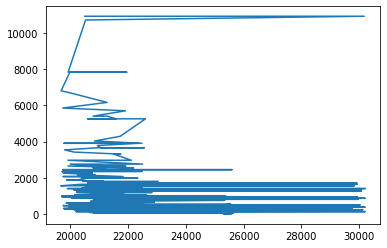

In [9]:
anl_df.uids.value_counts().plot()

76252
170


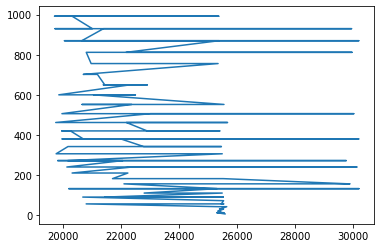

In [34]:
#seeing above graph we conclude that most questions have around 2000 combinations of entity-relations in Wiki KG
#So for building train set of our models, we also take only those question uids which form max 2000 ent-rel combin.
sel_df = anl_df[anl_df['uids'].map(anl_df['uids'].value_counts()) <= 2000]
print(len(sel_df))
print(len(sel_df.uids.unique()))
sel_df.uids.value_counts().plot()

In [36]:
senAB_df = pd.read_json('../data_files/lcquad2_senAB_290_each_class.json')
print(len(senAB_df))
senAB_df.tail(2)

4809


,uids,ques,ent,rel,ent_ids,rel_ids,req_ent,req_rel,actual_rel_ids
4807,10050,where is the filming location and the narrativ...,[forrest_gump],producer; instance of; director; production co...,[Q134773],p162; p31; p57; p272; p344; p364; p58; p166; p...,1,2,p915; p840;
4808,9830,who was the inventor and what is the history o...,[periodic table],depicts; main subject; permanent duplicated it...,[Q10693],p180; p921; p2959; p1269; p31; p61; p279; p144...,1,2,p2184; p61;


In [38]:
#Creating a function to form a combined df of all uids for which count is <= 1000 to form train test sets
def restrict_uids_val_cnt(inp_file,itr):
    anl_df = pd.read_json(inp_file)
    sel_df = anl_df[anl_df['uids'].map(anl_df['uids'].value_counts()) <= 1000]
    sel_df.to_json('../data_files/inp_rev/lcquad2_senAB_sim_l1kr_'+str(itr)+'.json', orient='records', indent=len(sel_df.columns)) 

In [45]:
#train, earlier was 23719288,  616252 with val_counts of combination <= 1000
#earlier was 6643, 4297 with val_counts of combination <= 1000
#earlier was 4798, 3565 with val_counts of combination <= 1000
final_df.head(2)

616252
4297
3565


,uids,sent_A,sent_B,ent_rel_cdd,scores
0,23956,tell me traditional fairy tale whose name has ...,traditional fairy tale; subclass of ;,Q42402646; p279 ;,0
1,23956,tell me traditional fairy tale whose name has ...,traditional fairy tale; instance of ;,Q42402646; p31 ;,1


### Creating train, test and validation sets for sentence_similarity models (bi-LSTM with attention, CNN, RNN)

In [68]:
#we build the sets in form of .txt files with following as header row
#pair_ID sentence_A      sentence_B      relatedness_score
#writing a function for stratified train test dev split
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [119]:
#to_csv_df = final_df[['uids','sent_A','sent_B','scores']]
#to_csv_df.to_csv('../data_files/lcq2_sentAB_sim_9June.csv')  #comment if already saved
to_csv_df = pd.read_csv('../data_files/lcq2_sentAB_sim_9June.csv')   #uncomment if already saved
to_csv_df.rename(columns={to_csv_df.columns[0]: "id" }, inplace = True)
to_csv_df.head(2)

,id,uids,sent_A,sent_B,scores
0,0,23956,tell me traditional fairy tale whose name has ...,traditional fairy tale; subclass of ;,0
1,1,23956,tell me traditional fairy tale whose name has ...,traditional fairy tale; instance of ;,1


In [132]:
len(to_csv_df)

616252

In [32]:
test_df = pd.read_csv('../data_files/lcq2_sentAB_sim_June10_test.txt',delimiter='\t') #267963 CORRECT rec test
print(len(test_df))
test_df.head(2)

267963


,pair_ID,sentence_A,sentence_B,relatedness_score
0,0,what is a human action that has the word zurgr...,human action; instance of ;,1
1,1,what is a human action that has the word zurgr...,human action; subclass of ;,0


In [33]:
#making val set from test itself, so train set can be larger
val_df = test_df[:134201]
test_df = test_df[134201:268403]
val_df.to_csv('../data_files/lcq2_sentAB_sim_June10_val_red.txt',sep='\t',index=False)
test_df.to_csv('../data_files/lcq2_sentAB_sim_June10_test_red.txt',sep='\t',index=False)

In [134]:
train_df = format_df(to_csv_df,'train')

train 616252


In [130]:
test_df.relatedness_score.isnull().any()

False

#### unstratified way of splitting into train test and val

In [ ]:
#df_train = to_csv_df[:14231572]
#df_test = to_csv_df[14231572:18975431]
#df_val = to_csv_df[18975431:23719288]

#### stratified way of splitting into train test and val

In [69]:
df_train, df_val, df_test = train_validate_test_split(to_csv_df)

In [70]:
#write these files to .txt files
format_df(df_train,'train')
format_df(df_test,'test')
format_df(df_val,'val')

train 369751
test 123251
val 123250


In [53]:
#writing a reduced test file for faster score computation by model
#df_test_red = df_test[:5000]
#format_df(df_test_red,'red_test')

red_test 5000


In [125]:
df_train = pd.read_csv('../data_files/lcq2_sentAB_sim_June9_train.txt',delimiter='\t')
df_test = pd.read_csv('../data_files/lcq2_sentAB_sim_June9_test.txt',delimiter='\t')
df_val = pd.read_csv('../data_files/lcq2_sentAB_sim_June9_val.txt',delimiter='\t')
print(len(df_test))
df_test.head(2)

123251


,pair_ID,sentence_A,sentence_B,relatedness_score
0,25016,tell me me a norse deity whose name consist of...,norse mythology; has part; category combines t...,0
1,25136,what is the name of the professional sports le...,october; day in year for periodic occurrence; ...,0


In [127]:
#for bimpm model, merging train and test as another test set is availble now from actual test set of lcq2
#lcq2_train_sen_sim_10June_df = pd.concat([df_train,df_test])
print(len(lcq2_train_sen_sim_10June_df))
lcq2_train_sen_sim_10June_df.to_csv('../data_files/lcq2_train_sen_sim_10June.txt',sep='\t',index=False)

493002


### Creating train and test sets for XGBoost model using BERT Embeddings of both Sentences A+B

In [84]:
print(len(to_csv_df))
to_csv_df.head(2)

616252


,id,sent_A,sent_B,scores
0,23956,tell me traditional fairy tale whose name has ...,traditional fairy tale; subclass of ;,0
1,23956,tell me traditional fairy tale whose name has ...,traditional fairy tale; instance of ;,1


#### 1) Concat sent_A & sent_B and then produce BERT Embedding of this concatenated sentence to pass as X & score as y

In [76]:
#Make train set bigger by concatenating train and val sets as in XGBoost we do not need to give val set separately
df_train = pd.concat([df_train,df_val])
print(len(df_train_XGB))

493001


In [86]:
#load if already saved
#df_train = pd.read_csv('../data_files/lcq2_sentAB_sim_June9_train.txt',delimiter='\t')
#df_test = pd.read_csv('../data_files/lcq2_sentAB_sim_June9_test.txt',delimiter='\t')
print(len(df_train))
print(len(df_test))
df_train_XGB.tail(2)

493001
123251


,pair_ID,sentence_A,sentence_B,relatedness_score,senAB,id,sent_A,sent_B,scores
14863,NaN,NaN,NaN,NaN,nan - nan,25075,what is the project involving nuclear weapons ...,nuclear weapon; main subject; prohibits ;,0
18987,NaN,NaN,NaN,NaN,nan - nan,25148,which is the research program that the objecti...,human genome; depicts; objective of project or...,0


In [81]:
#creating train and test sets for XGBoost model
df_train['senAB'] = df_train.apply(lambda row: str(row['sentence_A']) + ' - ' + str(row['sentence_B']), axis=1) 
lcq2_sim_bxgb_train_df = df_train[['senAB','relatedness_score']]
#df_test['senAB'] = df_test.apply(lambda row: str(row['sentence_A']) + ' - ' + str(row['sentence_B']), axis=1) 
#lcq2_sim_bxgb_test_df = df_test[['senAB','relatedness_score']]

In [82]:
#Writing to file
lcq2_sim_bxgb_train_df.to_csv('../data_files/lcq2_sentAB_sim_XGB_train.txt',index=False, sep='\t')
#lcq2_sim_bxgb_test_df.to_csv('../data_files/lcq2_sentAB_sim_XGB_test.txt',index=False, sep='\t')
#Reading an earlier saved version
#lcq2_sim_bxgb_train_df = pd.read_csv('../data_files/lcq2_sentAB_sim_XGB_train.txt',delimiter='\t')
#lcq2_sim_bxgb_test_df = pd.read_csv('../data_files/lcq2_sentAB_sim_XGB_test.txt',delimiter='\t')

In [75]:
print(len(lcq2_sim_bxgb_train_df))
print(len(lcq2_sim_bxgb_test_df))

369751
123251


In [65]:
sample_train_df = lcq2_sim_bxgb_train_df[:20]
sample_train_df.head(2)

,senAB,relatedness_score
0,which is the olympic sport that is an authorit...,0
1,which is the association of the chairperson th...,0


In [ ]:
#Now form BERT embeddings of the senAB field for all questions
#checking how long it takes to create first 20 bert embeddings
start = time.time()
np.save('../data_files/lcq2_sim_bertE_xgb_test_X.npy', np.array(phrase_vectors(list(lcq2_sim_bxgb_test_df.senAB))))
np.save('../data_files/lcq2_sim_bertE_xgb_test_y.npy', np.array(list(lcq2_sim_bxgb_test_df.relatedness_score)))
end = time.time()
print('length of test set is: ',len(lcq2_sim_bxgb_test_df))
print('Time taken to produce Bert embeddings for test set is:',(end - start))

In [6]:
test_X = np.load('../data_files/lcq2_sim_bertE_xgb_test_X.npy')
test_y = np.load('../data_files/lcq2_sim_bertE_xgb_test_y.npy')
print(sum(test_y))
test_y[0]

901


1

### 20.06.2021

In [7]:
train_df = pd.read_csv('../data_files/lcq2_sentAB_sim_June12_train.txt', delimiter='\t')
val_df = pd.read_csv('../data_files/lcq2_sentAB_sim_June12_val_red.txt', delimiter='\t')
test_df = pd.read_csv('../data_files/lcq2_sentAB_sim_June12_test_red.txt', delimiter='\t')
print(len(train_df))
print(len(val_df))
print(len(test_df))

1166508
134590
133373


In [10]:
train_df.head(2)

,pair_ID,sentence_A,sentence_B,relatedness_score
0,0,tell me traditional fairy tale whose name has ...,traditional fairy tale; subclass of ;,0
1,1,tell me traditional fairy tale whose name has ...,traditional fairy tale; instance of ;,1


In [16]:
print(train_df.sentence_A.isna().any())
print(train_df.sentence_B.isna().any())
print(train_df.relatedness_score.isna().any())
print(train_df.pair_ID.isna().any())
print(val_df.sentence_A.isna().any())
print(val_df.sentence_B.isna().any())
print(val_df.relatedness_score.isna().any())
print(val_df.pair_ID.isna().any())
print(test_df.sentence_A.isna().any())
print(test_df.sentence_B.isna().any())
print(test_df.relatedness_score.isna().any())
print(test_df.pair_ID.isna().any())

False
False
False
False
False
False
False
False
False
False
False
False


False
False
False


### Adding correct entity relation to that brought on based on entity

In [5]:
#senAB_df = pd.read_json('../data_files/lcquad2_senAB.json')
senAB_df.head(2)

,uids,ques,ent,rel,ent_ids,rel_ids,req_ent,req_rel
0,23956,tell me traditional fairy tale whose name has ...,[traditional fairy tale],instance of; subclass of; has quality; differe...,[Q42402646],p31; p279; p1552; p1889; p136; p144; p361; p18...,1,1
1,25156,tell me the female beauty pageant that operate...,[all countries],instance of; said to be the same as; country; ...,[Q62900839],p31; p460; p17; p2541; ;,2,2


In [6]:
lcq2_all_test_df = pd.read_json('../data_files/lcquad2.0.1_test_ent_mask_ques_emb_rev_22April.json')
print(len(lcq2_all_test_df))
lcq2_all_test_df.head(2)

5969


,uid,NNQT_question,question,sparql_wikidata,sparql_dbpedia18,template,template_id,paraphrased_question,type,ent_masked_ques,question_pos,question_with_pos,ques_pos_vec,ques_emb
0,20258,What is the {country} for {head of state} of {...,Who is the country for head of state of Mahmo...,select distinct ?sbj where { ?sbj wdt:P35 wd:...,select distinct ?subj where { ?statement <http...,<?S P O ; ?S InstanceOf Type>,10,What country is Mahmoud Abbas the head of stat...,test,who is the country for head of state of [Enti...,WP VBZ DT NN IN NN IN NN IN NNP NNP,Who/WP is/VBZ the/DT country/NN for/IN head/NN...,"[0.0, 0.0, 1.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, ...","[-0.3000952899, -0.1636392325, 0.2997020781, -..."
1,7141,What is {population} of {Somalia} that is {poi...,What was the population of Somalia in 2009-0-0?,SELECT ?obj WHERE { wd:Q1045 p:P1082 ?s . ?s p...,select distinct ?obj where {\n?statement <htt...,(E pred F) prop ?value,7,"As of 2009, how many people lived in Somalia?",test,what was the population of [Entity1] in 2009-0-0?,WP VBD DT NN IN NNP IN CD,What/WP was/VBD the/DT population/NN of/IN Som...,"[0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, ...","[-0.4244708419, -0.3521376252, 0.4652319551000..."


In [7]:
lcq2_MT_test_df = pd.read_json('../data_files/lcq2_MT_test.json')
print(len(lcq2_MT_test_df))
lcq2_MT_test_df.head(2)

5969


,uid,question,sparql_wikidata,template_id,question_pos,ent_masked_ques,question_with_pos,triples_template
0,20258,Who is the country for head of state of Mahmo...,select distinct ?sbj where { ?sbj wdt:P35 wd:...,10,WP VBZ DT NN IN NN IN NN IN NNP NNP,who is the country for head of state of [Enti...,Who/WP is/VBZ the/DT country/NN for/IN head/NN...,subject < head of state > [ mahmoud abbas ] . ...
1,7141,What was the population of Somalia in 2009-0-0?,SELECT ?obj WHERE { wd:Q1045 p:P1082 ?s . ?s p...,7,WP VBD DT NN IN NNP IN CD,what was the population of [Entity1] in 2009-0-0?,What/WP was/VBD the/DT population/NN of/IN Som...,[ somalia ] < population > ?s . ?s < populatio...


# 18th May 2021

## Data Processing for Machine Translation

In [42]:
lcq_emq_emb_train_df = pd.read_json('../data_files/lcquad2.0.1_train_ent_mask_ques_emb_rev_22April.json')
lcq_emq_emb_test_df = pd.read_json('../data_files/lcquad2.0.1_test_ent_mask_ques_emb_rev_22April.json')

In [43]:
#drop unwanted field sparql_dbpedia18
lcq_emq_emb_train_df.drop("sparql_dbpedia18", axis=1, inplace=True)
lcq_emq_emb_test_df.drop("sparql_dbpedia18", axis=1, inplace=True)

In [44]:
#query to fetch relation label
qry_rel_1 = """ SELECT ?wdLabel WHERE {  VALUES (?wdt) {(wdt:"""
qry_rel_2 = """)} ?wd wikibase:directClaim ?wdt .
               SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
               }"""

In [45]:
#function to fetch relation of label
def fetch_relation_label(qry):
    res = ''
    sparql.setQuery(qry)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert() 
    for item in results['results']['bindings']: 
        res = item['wdLabel']['value'].lower().strip()
    return res

In [46]:
ctr_excp = 0
def replace_qry_contents(qry):
    global ctr_excp
    rev_qry = ''
    lst_words = []  
    if '?sbj_label' in qry:
       qry = qry.replace('?sbj_label','subject_label')
    if '?sbj' in qry:
       qry = qry.replace('?sbj','subject')  
    if '?obj' in qry:
       qry = qry.replace('?obj','object') 
    if ('?value' in qry) and not (('?value1' in qry) or ('?value2' in qry)):
       qry = qry.replace('?value','value') 
    if '?value1' in qry:
       qry = qry.replace('?value1','value_1') 
    if '?value2' in qry:
       qry = qry.replace('?value2','value_2') 
    if '?obj' in qry:
       qry = qry.replace('?obj','object')
    if '?answer' in qry:
       qry = qry.replace('?answer','answer')
    if '?ent' in qry:
       qry = qry.replace('?ent','entity')
    if '?ans_1' in qry:
       qry = qry.replace('?ans_1','ans_1')
    if '?ans_2' in qry:
       qry = qry.replace('?ans_2','ans_2')
    #if '?' in qry:
    #   qry = qry.replace('?','')
    qry = qry.strip()
    qry_arr = qry.split(' ')
    #print(qry_arr)
    for item in qry_arr:
        fetched_label = ''
        if 'wd:' in item:
            #fetch label of the entity
            item = item.replace('}','').replace('.','')
            try:
               
               fetched_label = '[ ' + fetch_label(qry_pt1 + item.split(':')[-1] + qry_pt2) + ' ]'
               #print('fetched label is: ',fetched_label)
            except Exception as ex:
               ctr_excp += 1
               fetched_label = ' '
               print('Exception coming for query: ',(qry_pt1 + item.split(':')[-1] + qry_pt2))
               print(ex)
               print('\n')
        elif ('wdt:' in item) or ('p:' in item) or ('ps:' in item) or ('pq:' in item):
            #fetch label of the entity
            item = item.replace('}','').replace('.','')
            try:
               fetched_label = 'µ$' + fetch_relation_label(qry_rel_1 + item.split(':')[-1] + qry_rel_2) + '$µ'
               #print('fetched label of relation is: ',fetched_label)
            except Exception as ex:
               ctr_excp += 1
               fetched_label = ' '
               print('Exception coming for query: ',(qry_rel_1 + item.split(':')[-1] + qry_rel_2))
               print(ex)
               print('\n')
        else:
            fetched_label = item
        #append the fetched label into the words collection list
        lst_words.append(str(fetched_label).lower())
    for itm in lst_words:
        itm = itm.replace('{','').replace('}','')
        itm = itm.replace('µ$','< ').replace('$µ',' >')
        rev_qry += itm + ' '
    #remove part until where so that we get only triples
    rev_qry = rev_qry.split('where')[-1].strip()
    return rev_qry

In [47]:
#function to fetch and append triples templates in parts for a big dataframe
def add_triples_for_parts(df,num_parts):
    lst_col = list(df.columns)
    lst_col.append('triples_template')
    final_df = pd.DataFrame(columns=lst_col)   #initially an empty df is created as final_df
    global ctr_excp
    mul_factor = len(df)/num_parts
    for i in range(num_parts):               #to do in 6 parts
        st_idx = int(mul_factor * i)
        end_idx =  int(mul_factor * (i+1))
        new_df = df[st_idx:end_idx]
        new_df['triples_template'] = new_df['sparql_wikidata'].apply(lambda x:replace_qry_contents(x))
        file_name = '../data_files/lcquad2_MT_train_p'+str(i+1)+'_n.json'
        new_df.to_json(file_name, orient='records', indent=len(new_df.columns))
        print('Number of exceptions encountered: ',ctr_excp)
        ctr_excp = 0
        final_df = pd.concat([final_df,new_df])
    return final_df

In [48]:
#for training set fetch and append triple labels template fields part wise in 6 parts and then concatenate them
lcq2_MT_train_df = add_triples_for_parts(lcq_emq_emb_train_df,6)

Exception coming for query:  select distinct ?label where { wd:Q13406463 rdfs:label ?label . FILTER (langMatches( lang(?label), "EN" ) ) } LIMIT 1
Remote end closed connection without response


Number of exceptions encountered:  1
Number of exceptions encountered:  0
Exception coming for query:   SELECT ?wdLabel WHERE {  VALUES (?wdt) {(wdt://dbpediaorg/ontology/City')))} ?wd wikibase:directClaim ?wdt .
               SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
               }
QueryBadFormed: a bad request has been sent to the endpoint, probably the sparql query is bad formed. 

Response:
b'SPARQL-QUERY: queryStr= SELECT ?wdLabel WHERE {  VALUES (?wdt) {(wdt://dbpediaorg/ontology/City\')))} ?wd wikibase:directClaim ?wdt .\n               SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }\n               }\njava.util.concurrent.ExecutionException: org.openrdf.query.MalformedQueryException: Encountered " "/" "/ "" at line 1, column 47.\nWas expect

Exception coming for query:   SELECT ?wdLabel WHERE {  VALUES (?wdt) {(wdt://dbpediaorg/ontology/State')))} ?wd wikibase:directClaim ?wdt .
               SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
               }
QueryBadFormed: a bad request has been sent to the endpoint, probably the sparql query is bad formed. 

Response:
b'SPARQL-QUERY: queryStr= SELECT ?wdLabel WHERE {  VALUES (?wdt) {(wdt://dbpediaorg/ontology/State\')))} ?wd wikibase:directClaim ?wdt .\n               SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }\n               }\njava.util.concurrent.ExecutionException: org.openrdf.query.MalformedQueryException: Encountered " "/" "/ "" at line 1, column 47.\nWas expecting one of:\n    ")" ...\n    "true" ...\n    "false" ...\n    "UNDEF" ...\n    <Q_IRI_REF> ...\n    <PNAME_NS> ...\n    <PNAME_LN> ...\n    <INTEGER> ...\n    <INTEGER_POSITIVE> ...\n    <INTEGER_NEGATIVE> ...\n    <DECIMAL> ...\n    <DECIMAL_POSITIVE> ...\n    <DEC

Exception coming for query:   SELECT ?wdLabel WHERE {  VALUES (?wdt) {(wdt:P881)} ?wd wikibase:directClaim ?wdt .
               SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
               }
'wdLabel'


Exception coming for query:   SELECT ?wdLabel WHERE {  VALUES (?wdt) {(wdt://dbpediaorg/ontology/Settlement')))} ?wd wikibase:directClaim ?wdt .
               SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
               }
QueryBadFormed: a bad request has been sent to the endpoint, probably the sparql query is bad formed. 

Response:
b'SPARQL-QUERY: queryStr= SELECT ?wdLabel WHERE {  VALUES (?wdt) {(wdt://dbpediaorg/ontology/Settlement\')))} ?wd wikibase:directClaim ?wdt .\n               SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }\n               }\njava.util.concurrent.ExecutionException: org.openrdf.query.MalformedQueryException: Encountered " "/" "/ "" at line 1, column 47.\nWas expecting one of:\n    ")" ...\n    "t

Number of exceptions encountered:  4
Exception coming for query:   SELECT ?wdLabel WHERE {  VALUES (?wdt) {(wdt://dbpediaorg/ontology/State')))} ?wd wikibase:directClaim ?wdt .
               SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
               }
QueryBadFormed: a bad request has been sent to the endpoint, probably the sparql query is bad formed. 

Response:
b'SPARQL-QUERY: queryStr= SELECT ?wdLabel WHERE {  VALUES (?wdt) {(wdt://dbpediaorg/ontology/State\')))} ?wd wikibase:directClaim ?wdt .\n               SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }\n               }\njava.util.concurrent.ExecutionException: org.openrdf.query.MalformedQueryException: Encountered " "/" "/ "" at line 1, column 47.\nWas expecting one of:\n    ")" ...\n    "true" ...\n    "false" ...\n    "UNDEF" ...\n    <Q_IRI_REF> ...\n    <PNAME_NS> ...\n    <PNAME_LN> ...\n    <INTEGER> ...\n    <INTEGER_POSITIVE> ...\n    <INTEGER_NEGATIVE> ...\n    <DECIMAL> ...\

Exception coming for query:  select distinct ?label where { wd:Q3624078 rdfs:label ?label . FILTER (langMatches( lang(?label), "EN" ) ) } LIMIT 1
Remote end closed connection without response


Exception coming for query:   SELECT ?wdLabel WHERE {  VALUES (?wdt) {(wdt://dbpediaorg/ontology/City')))} ?wd wikibase:directClaim ?wdt .
               SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
               }
QueryBadFormed: a bad request has been sent to the endpoint, probably the sparql query is bad formed. 

Response:
b'SPARQL-QUERY: queryStr= SELECT ?wdLabel WHERE {  VALUES (?wdt) {(wdt://dbpediaorg/ontology/City\')))} ?wd wikibase:directClaim ?wdt .\n               SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }\n               }\njava.util.concurrent.ExecutionException: org.openrdf.query.MalformedQueryException: Encountered " "/" "/ "" at line 1, column 47.\nWas expecting one of:\n    ")" ...\n    "true" ...\n    "false" ...\n    "UNDEF" ...\

Number of exceptions encountered:  3
Number of exceptions encountered:  0
Number of exceptions encountered:  0


#### Test df

In [49]:
lcq_emq_emb_test_df['triples_template'] = lcq_emq_emb_test_df['sparql_wikidata'].apply(lambda x:replace_qry_contents(x))
print('Number of exceptions encountered: ',ctr_excp)
ctr_excp = 0

Exception coming for query:   SELECT ?wdLabel WHERE {  VALUES (?wdt) {(wdt://wwwwikidataorg/entity/P17')))} ?wd wikibase:directClaim ?wdt .
               SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
               }
QueryBadFormed: a bad request has been sent to the endpoint, probably the sparql query is bad formed. 

Response:
b'SPARQL-QUERY: queryStr= SELECT ?wdLabel WHERE {  VALUES (?wdt) {(wdt://wwwwikidataorg/entity/P17\')))} ?wd wikibase:directClaim ?wdt .\n               SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }\n               }\njava.util.concurrent.ExecutionException: org.openrdf.query.MalformedQueryException: Encountered " "/" "/ "" at line 1, column 47.\nWas expecting one of:\n    ")" ...\n    "true" ...\n    "false" ...\n    "UNDEF" ...\n    <Q_IRI_REF> ...\n    <PNAME_NS> ...\n    <PNAME_LN> ...\n    <INTEGER> ...\n    <INTEGER_POSITIVE> ...\n    <INTEGER_NEGATIVE> ...\n    <DECIMAL> ...\n    <DECIMAL_POSITIVE> ...\n    <DEC

Exception coming for query:   SELECT ?wdLabel WHERE {  VALUES (?wdt) {(wdt://dbpediaorg/ontology/Organisation')))} ?wd wikibase:directClaim ?wdt .
               SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
               }
QueryBadFormed: a bad request has been sent to the endpoint, probably the sparql query is bad formed. 

Response:
b'SPARQL-QUERY: queryStr= SELECT ?wdLabel WHERE {  VALUES (?wdt) {(wdt://dbpediaorg/ontology/Organisation\')))} ?wd wikibase:directClaim ?wdt .\n               SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }\n               }\njava.util.concurrent.ExecutionException: org.openrdf.query.MalformedQueryException: Encountered " "/" "/ "" at line 1, column 47.\nWas expecting one of:\n    ")" ...\n    "true" ...\n    "false" ...\n    "UNDEF" ...\n    <Q_IRI_REF> ...\n    <PNAME_NS> ...\n    <PNAME_LN> ...\n    <INTEGER> ...\n    <INTEGER_POSITIVE> ...\n    <INTEGER_NEGATIVE> ...\n    <DECIMAL> ...\n    <DECIMAL_POSITIVE>

Number of exceptions encountered:  2


In [40]:
#sel_df = lcq_emq_emb_test_df[:2]
#print(len(sel_df))
print(replace_qry_contents(sel_df.sparql_wikidata.values[0]))

subject < head of state > [ mahmoud abbas ] . subject < instance of > [ country ]


In [50]:
#saving train and test dfs
lcq2_MT_train_df.to_json('../data_files/lcq2_MT_train_df_n.json', orient='records', indent=len(lcq2_MT_train_df.columns))
lcq_emq_emb_test_df.to_json('../data_files/lcq2_MT_test_n.json', orient='records', indent=len(lcq_emq_emb_test_df.columns))
lcq_emq_emb_test_df.head(1)

,uid,NNQT_question,question,sparql_wikidata,template,template_id,paraphrased_question,type,ent_masked_ques,question_pos,question_with_pos,ques_pos_vec,ques_emb,triples_template
0,20258,What is the {country} for {head of state} of {...,Who is the country for head of state of Mahmo...,select distinct ?sbj where { ?sbj wdt:P35 wd:...,<?S P O ; ?S InstanceOf Type>,10,What country is Mahmoud Abbas the head of stat...,test,who is the country for head of state of [Enti...,WP VBZ DT NN IN NN IN NN IN NNP NNP,Who/WP is/VBZ the/DT country/NN for/IN head/NN...,"[0.0, 0.0, 1.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, ...","[-0.3000952899, -0.1636392325, 0.2997020781, -...",subject < head of state > [ mahmoud abbas ] . ...


#### Shortening the dataset to store only fields required for Machine Translation

In [51]:
lcq2_MT_test_sh_df = lcq_emq_emb_test_df[['uid','question','sparql_wikidata','template_id','question_pos','ent_masked_ques','question_with_pos','triples_template']]
lcq2_MT_train_sh_df = lcq2_MT_train_df[['uid','question','sparql_wikidata','template_id','question_pos','ent_masked_ques','question_with_pos','triples_template']]
#saving the DFs...later upload on gitlab
lcq2_MT_train_sh_df.to_json('../data_files/lcq2_MT_train_sh_n.json', orient='records', indent=len(lcq2_MT_train_sh_df.columns))
lcq2_MT_test_sh_df.to_json('../data_files/lcq2_MT_test_sh_n.json', orient='records', indent=len(lcq2_MT_test_sh_df.columns))

In [4]:
lcq2_MT_test_sh_df = pd.read_json('../data_files/lcq2_MT_test.json')

In [5]:
lcq2_MT_test_sh_df.head(2)

,uid,question,sparql_wikidata,template_id,question_pos,ent_masked_ques,question_with_pos,triples_template
0,20258,Who is the country for head of state of Mahmo...,select distinct ?sbj where { ?sbj wdt:P35 wd:...,10,WP VBZ DT NN IN NN IN NN IN NNP NNP,who is the country for head of state of [Enti...,Who/WP is/VBZ the/DT country/NN for/IN head/NN...,subject < head of state > [ mahmoud abbas ] . ...
1,7141,What was the population of Somalia in 2009-0-0?,SELECT ?obj WHERE { wd:Q1045 p:P1082 ?s . ?s p...,7,WP VBD DT NN IN NNP IN CD,what was the population of [Entity1] in 2009-0-0?,What/WP was/VBD the/DT population/NN of/IN Som...,[ somalia ] < population > ?s . ?s < populatio...


In [6]:
lcq2_MT_test_sh_df.triples_template.values[0]

'subject < head of state > [ mahmoud abbas ] . subject < instance of > [ country ]'

In [7]:
#for experiment 1, input and output fields
print('Experiment 1 Input Field')
print(lcq2_MT_test_sh_df.question.values[0])
print('\n')
print('Experiment 1 Output Field')
print(lcq2_MT_test_sh_df.triples_template.values[0])

Experiment 1 Input Field
Who is the  country for head of state of Mahmoud Abbas


Experiment 1 Output Field
subject < head of state > [ mahmoud abbas ] . subject < instance of > [ country ]


In [8]:
#for experiment 2, input and output fields
print('Experiment 2 Input Field')
print(lcq2_MT_test_sh_df.question_with_pos.values[0])
print('\n')
print('Experiment 2 Output Field')
print(lcq2_MT_test_sh_df.triples_template.values[0])

Experiment 2 Input Field
Who/WP is/VBZ the/DT country/NN for/IN head/NN of/IN state/NN of/IN Mahmoud/NNP Abbas/NNP


Experiment 2 Output Field
subject < head of state > [ mahmoud abbas ] . subject < instance of > [ country ]
